# Project 4 Data science OC 
## Forecasting the total electric consumption and the CO2 emissions of the Seatle buldings

> Background

Seatle intend to be a neutral city in 2050 with regard the CO2 emissions.<br>
Based on 2015 ans 2016 datas for this very city, the mission consist in forecasting the CO2 emissions and the total energy consumption of the city of Seatle.

Espcially a focus has to be done on non residential buildings.

The forecast has to be based on the following:
* Size and usage of the buildings
* Maintenance and repair of those buildings
* Construction date

The energy star score relevance has to be evaluated in the CO2 emissions.


> Expectations

* Cleaning and exploratory
* Machine learning modeling for prediction purpose
* Hyperparameters tunning
* Choice of a set of models. 

# Table of contents

[Modules import](#module)

[Reading datas](#module)<br>
[Reading metadatas](#meta)

[Checking NaN in both datasets](#nan)

[Creating one unique Dataset](#unique)

[Dataset cleaning](#cleaning)

[Feature engineering](#feature_eng)

[Final preparation](#final_prep)

# Modules import <a class="anchor" id="module"></a>

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import re

import missingno as msno

import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns

import ast

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Binarizer

import plotly.express as px

#### Function declaration

In [2]:
def columns_comparison(df1, df2):
    #check columns in 2015 not in 2016
    not_in_df2= df1.columns[~df1.columns.isin(df2.columns)]
    #check columns in 2016 not in 2015
    not_in_df1= df2.columns[~df2.columns.isin(df1.columns)]
    #print(not_in_df2)
    #print(not_in_df1)
    return not_in_df1, not_in_df2

def visualisation_ghg(variable,df):
    my_mean=df["TotalGHGEmissions"].mean()
    fig=plt.figure(figsize=[18,7])
    fig.patch.set_facecolor('#E0E0E0')
    fig.patch.set_alpha(0.7)
    plt.title("C02 emissions distribution by {}".format(variable),size=16)
    sns.boxplot(x=variable, y="TotalGHGEmissions", data=df,color="#cbd1db",width=0.5,showfliers=False,showmeans=True)
    plt.hlines(y=my_mean,xmin=-0.5,xmax=len(df[variable].unique())-0.5,color="#6d788b",ls="--",label="Global mean")

    plt.ylabel("Total GHG emissions",size=14)
    plt.xticks(range(0,len(df[variable].unique())),df[variable].unique(),rotation=90)
    plt.legend()
    plt.grid()
    plt.show()

def visualisation_eui(variable,df):
    my_mean=df["SiteEnergyUse(kBtu)"].mean()
    fig=plt.figure(figsize=[18,7])
    fig.patch.set_facecolor('#E0E0E0')
    fig.patch.set_alpha(0.7)
    plt.title("Site energy used by {}".format(variable),size=16)
    sns.boxplot(x=variable, y="SiteEnergyUse(kBtu)", data=df,color="#cbd1db",width=0.5,showfliers=False,showmeans=True)
    plt.hlines(y=my_mean,xmin=-0.5,xmax=len(df[variable].unique())-0.5,color="#6d788b",ls="--",label="Mean")

    plt.ylabel("Site energy used (Kbtu)",size=14)
    plt.xticks(range(0,len(df[variable].unique())),df[variable].unique(),rotation=90)
    plt.legend()
    plt.grid()
    plt.show()

def ploting_distirbution(df, columns_list):

    plt.figure(figsize = (15, 20))
    i= 1
    for e in columns_list:
        plt.subplot(len(columns_list),2,i)
        sns.boxplot(x=df[e], width=0.5, color='#2E56D3')
        plt.title(f'Variable {e} boxlot grade {e.upper()}')
        plt.ylabel('Value')
        plt.xlabel('')

        i += 1

        plt.subplot(len(columns_list),2,i)
        sns.histplot(x=df[e], kde=True, color='#2E56D3')
        plt.title(f'Variable {e} histplot grade {e.upper()}')
        plt.xlabel('Value')

        i += 1

    plt.suptitle(f'Distribution of the quantitative variables', fontsize=25, y=1.01)
    # plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    plt.tight_layout()

def way_type_extraction(row):
    '''
    Research a pattern of type of way (stree, avenue etc)
    '''
    row= row.upper()
    if (re.search('WAY', row)):
        return 'WAY'
    elif (re.search('ST| ST$| STREET', row)):
        return 'STREET'
    elif (re.search('AVE|AVENUE', row)):
        return 'AVENUE'
    else:
        return 'other'

# Reading datas <a class="anchor" id="reading"></a>

In [3]:
df_2015 = pd.read_csv('src/2015-building-energy-benchmarking.csv')
df_2016 = pd.read_csv('src/2016-building-energy-benchmarking.csv')

In [4]:
df_2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   OSEBuildingID                                                  3340 non-null   int64  
 1   DataYear                                                       3340 non-null   int64  
 2   BuildingType                                                   3340 non-null   object 
 3   PrimaryPropertyType                                            3340 non-null   object 
 4   PropertyName                                                   3340 non-null   object 
 5   TaxParcelIdentificationNumber                                  3338 non-null   object 
 6   Location                                                       3340 non-null   object 
 7   CouncilDistrictCode                                         

In [5]:
df_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

> Comparing columns in both dataset

In [6]:
columns_comparison(df_2015, df_2016)

(Index(['Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude',
        'Comments', 'TotalGHGEmissions', 'GHGEmissionsIntensity'],
       dtype='object'),
 Index(['Location', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
        'GHGEmissionsIntensity(kgCO2e/ft2)', 'Comment', '2010 Census Tracts',
        'Seattle Police Department Micro Community Policing Plan Areas',
        'City Council Districts', 'SPD Beats', 'Zip Codes'],
       dtype='object'))

We see that some columns are different, but seems to have their equivalent in both datasets for some of them.

In [7]:
df_2015.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,1,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,1,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,0.0,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,1,10.0,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,1.0,460.4,462.5,636.3,643.2,28229320.0,28363444.0,23458518.0,811521.0,2769023.0,20019.0,2001894.0,0.0,1936.34,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,1,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,67.0,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,1777841.0,6066245.0,87631.0,8763105.0,0.0,507.70,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576


In [8]:
df_2016.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


# Reading Metadatas <a class="anchor" id="meta"></a>

In [9]:
#read metadatas
df_2015_meta = pd.read_json('src/socrata_metadata_2015-building-energy-benchmarking.json', orient='index')
df_2016_meta = pd.read_json('src/socrata_metadata_2016-building-energy-benchmarking.json', orient='index')

In [10]:
df_2015_meta

,0
id,h7rm-fz6m
name,2015 Building Energy Benchmarking
assetType,dataset
attribution,City of Seattle
attributionLink,http://www.seattle.gov/environment
averageRating,0
createdAt,1492461362
description,Seattle’s Building Energy Benchmarking and Rep...
displayType,table
downloadCount,2905


In [11]:
df_2016_meta

,0
id,2bpz-gwpy
name,2016 Building Energy Benchmarking
assetType,dataset
attribution,City of Seattle
attributionLink,https://www.seattle.gov/energybenchmarking
averageRating,0
createdAt,1521070051
description,Seattle’s Building Energy Benchmarking and Rep...
displayType,table
downloadCount,2331


# Checking NaN datas in both datasets<a class="anchor" id="nan"></a>

<AxesSubplot:>

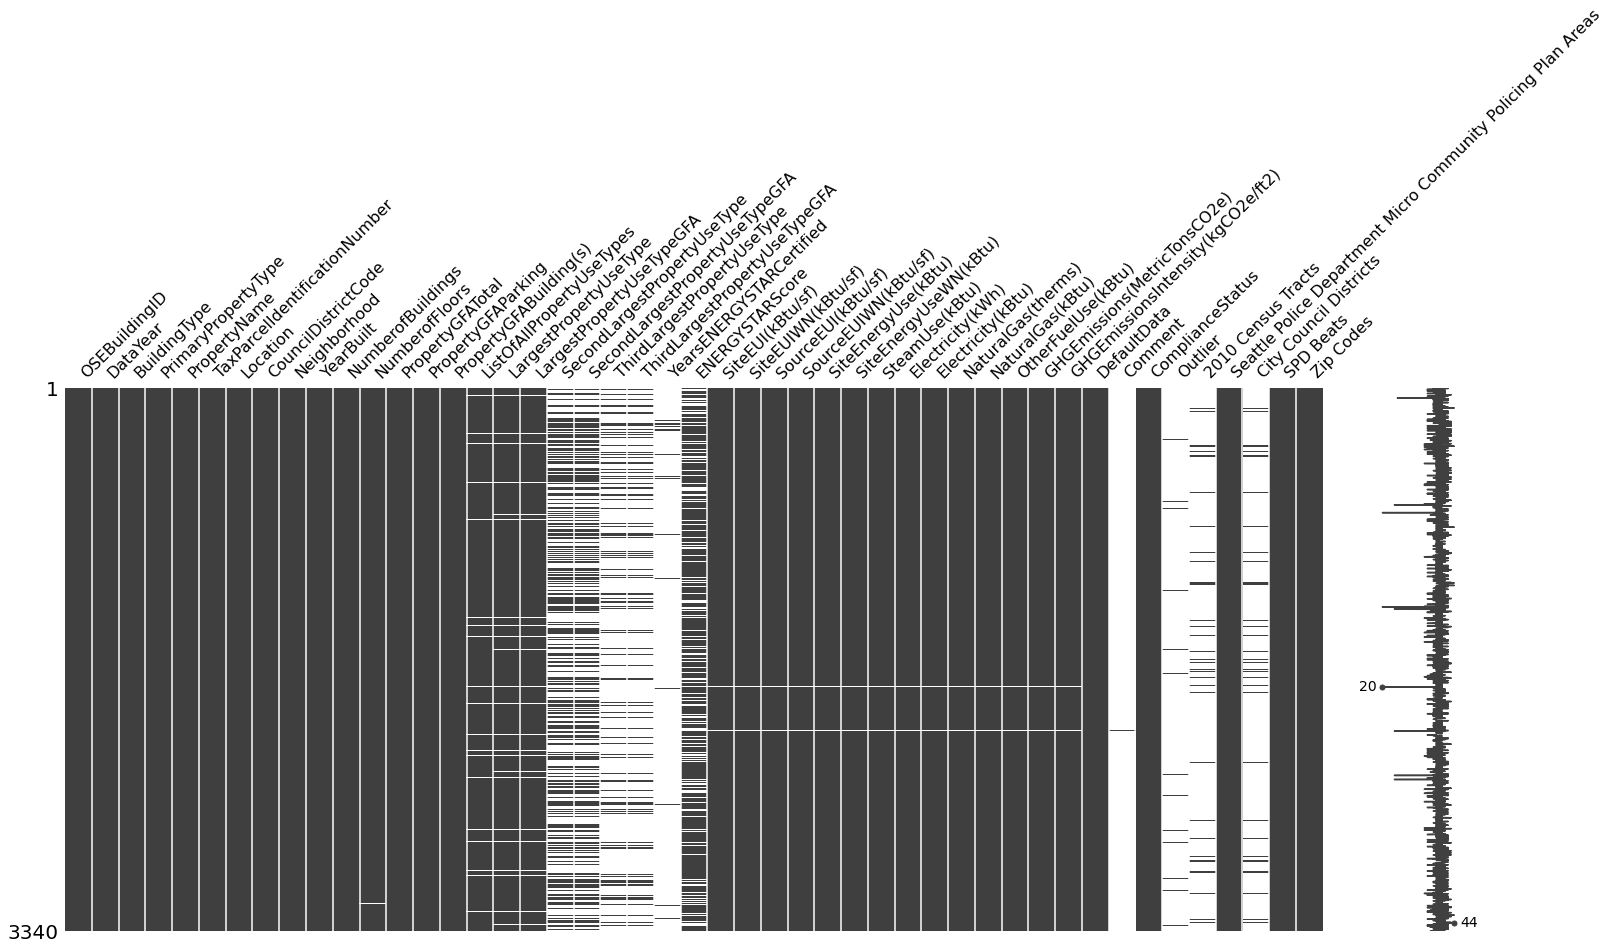

In [12]:
msno.matrix(df_2015)

<AxesSubplot:>

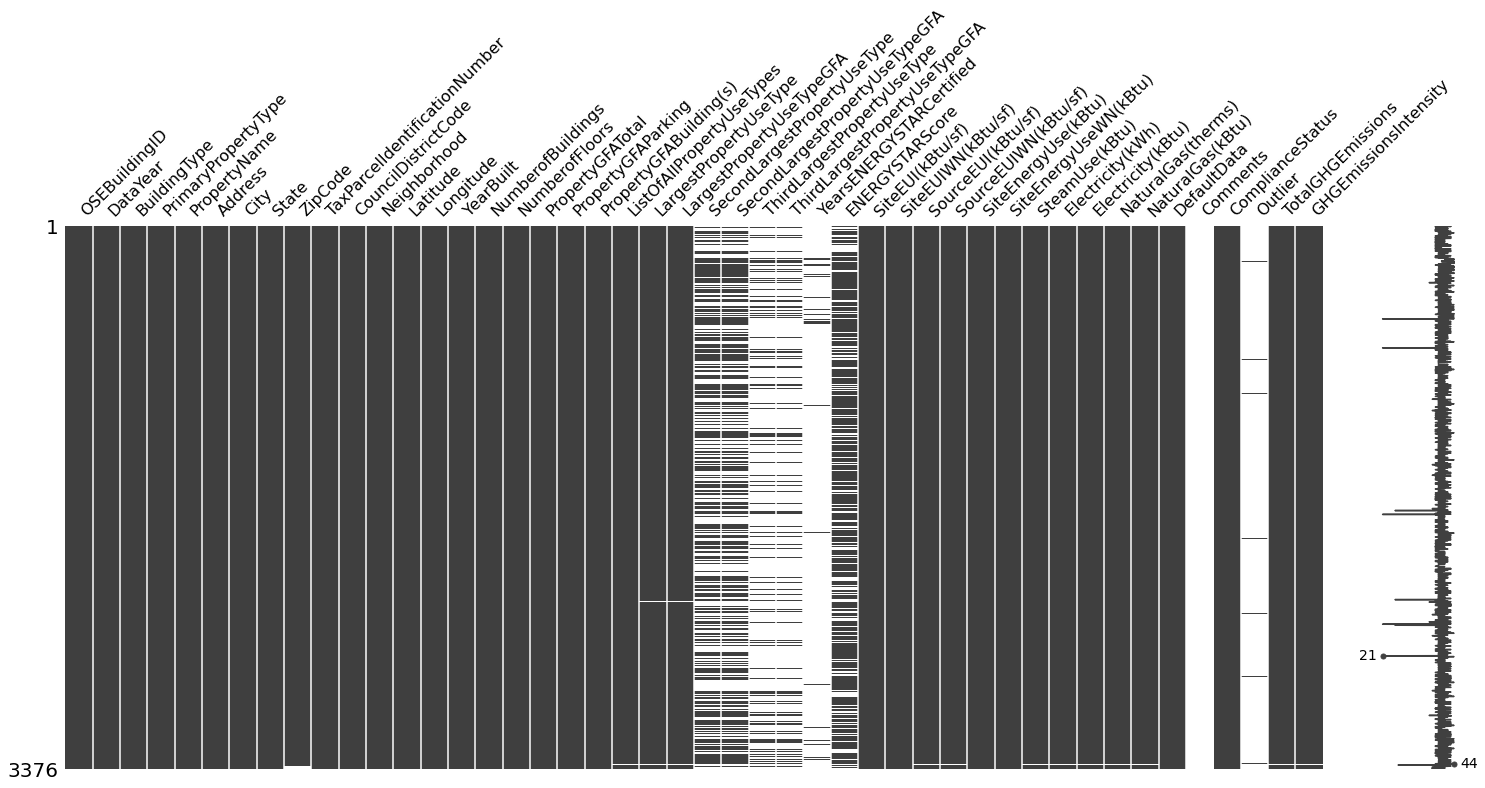

In [13]:
msno.matrix(df_2016)

# Creating one unique dataset<a class="anchor" id="unique"></a>

Since then we have saw that the columns of the two datasets at disposal are quite different.

As we saw, we have some columns not shared by the two dataset or at least columns with different names.

Let's check this.

We see that we have a variable in 2015: <br>
Location<br>
which seems to be potentially equal to the multiple variables in 2016:<br>
Address, City, State

Zipcode are in the two datasets but with a slightly different name.

Comments equally.

GHGemission and intensity hacve slightly different names as well.

We have in 2015 some variables like OtherFuelUse, census tracts, Seatle Police Department ... , City council districts, SPD beats which are not in 2016 as it seems.


We confirm here that we have in location the informaiton as dictionnary of the Latitude, Longitude, Adress, city state and zip code.
We are going to explode this in different columns

In [14]:
df_2015['Location'][0]

'{\'latitude\': \'47.61219025\', \'longitude\': \'-122.33799744\', \'human_address\': \'{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}\'}'

As we see, this is a strange type of dictionnaries that we have to clean first before any explode.

In [15]:
#transforming the actual dictionnary type
df_2015['Location'] = [ast.literal_eval(str(e)) for i, e in df_2015['Location'].iteritems()]

#exploding the column Location
df_2015 = pd.concat([df_2015.drop(['Location'], axis=1), df_2015['Location'].apply(pd.Series)], axis=1)

df_2015['human_address']

0       {"address": "405 OLIVE WAY", "city": "SEATTLE"...
1       {"address": "724 PINE ST", "city": "SEATTLE", ...
2       {"address": "1900 5TH AVE", "city": "SEATTLE",...
3       {"address": "620 STEWART ST", "city": "SEATTLE...
4       {"address": "401 LENORA ST", "city": "SEATTLE"...
                              ...                        
3335    {"address": "321 10TH AVE S", "city": "SEATTLE...
3336    {"address": "4123 12TH AVE NE", "city": "SEATT...
3337    {"address": "2030 8TH AVE", "city": "SEATTLE",...
3338    {"address": "3801 NE 77TH ST", "city": "SEATTL...
3339    {"address": "7540 37TH AVE NE", "city": "SEATT...
Name: human_address, Length: 3340, dtype: object

We see that now this has to be done on the column human address which is a dictionnary as well.

In [16]:
#transforming the actual dictionnary type
df_2015['human_address'] = [ast.literal_eval(str(e)) for i, e in df_2015['human_address'].iteritems()]

#exploding the column Location
df_2015 = pd.concat([df_2015.drop(['human_address'], axis=1), df_2015['human_address'].apply(pd.Series)], axis=1)

df_2015.head(1)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes,latitude,longitude,address,city,state,zip
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081,47.61219025,-122.33799744,405 OLIVE WAY,SEATTLE,WA,98101


OK now location is exploded in different columns we have to rename them so they have the same columns name than in df_2016.

In [17]:
df_2015.rename(columns={"latitude":"Latitude", "longitude":"Longitude",  "address":"Address", "city":"City",  "state":"State", "zip":"ZipCode"}, inplace=True)

In [18]:
#check columns in 2015 not in 2016
columns_comparison(df_2015, df_2016)

(Index(['Comments', 'TotalGHGEmissions', 'GHGEmissionsIntensity'], dtype='object'),
 Index(['OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
        'GHGEmissionsIntensity(kgCO2e/ft2)', 'Comment', '2010 Census Tracts',
        'Seattle Police Department Micro Community Policing Plan Areas',
        'City Council Districts', 'SPD Beats', 'Zip Codes'],
       dtype='object'))

It seems that TotalGHGEmissions' and GHGEmissions(MetricTonsCO2e) might be the same variables.

As well as GHGEmissionsIntensity(kgCO2e/ft2) and GHGEmissionsIntensity'might be the same.

Comments and Comment will be renamed as one unique typo.

In [19]:
#check of TotalGHGEmissions 2015 VS 2016
df_2015['GHGEmissions(MetricTonsCO2e)'].describe()

count     3330.000000
mean       110.094102
std        409.450179
min          0.000000
25%          9.265000
50%         32.740000
75%         88.642500
max      11824.890000
Name: GHGEmissions(MetricTonsCO2e), dtype: float64

In [20]:
df_2016['TotalGHGEmissions'].describe()

count     3367.000000
mean       119.723971
std        538.832227
min         -0.800000
25%          9.495000
50%         33.920000
75%         93.940000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64

We confirm the similarity of distribution and so, the two variables contain the same inforamtion for both years.
Let's rename the one in 2015.

In [21]:
df_2015.rename(columns={'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions'}, inplace=True)

In [22]:
#check of TotalGHGEmissionsIntensity 2015 VS 2016
df_2015['GHGEmissionsIntensity(kgCO2e/ft2)'].describe()

count    3330.000000
mean        0.985339
std         1.637172
min         0.000000
25%         0.080000
50%         0.460000
75%         1.180000
max        31.380000
Name: GHGEmissionsIntensity(kgCO2e/ft2), dtype: float64

In [23]:
df_2016['GHGEmissionsIntensity'].describe()

count    3367.000000
mean        1.175916
std         1.821452
min        -0.020000
25%         0.210000
50%         0.610000
75%         1.370000
max        34.090000
Name: GHGEmissionsIntensity, dtype: float64

We confirm the similarity of distribution and so, the two variables contain the same inforamtion for both years.
Let's rename the one in 2015.

In [24]:
df_2015.rename(columns={'GHGEmissionsIntensity(kgCO2e/ft2)': 'GHGEmissionsIntensity'}, inplace=True)

#renaming comments columns as well
df_2015.rename(columns={'Comment': 'Comments'}, inplace=True)

In [25]:
#check columns in 2015 not in 2016
not_in_2015, not_in_2016 = columns_comparison(df_2015, df_2016)

The columns that are still different in 2015 seems to be not usefull for our analysis so we'll drop them.

In [26]:
df_2015.drop(not_in_2016, axis = 1, inplace=True)

In [27]:
columns_comparison(df_2015, df_2016)

(Index([], dtype='object'), Index([], dtype='object'))

OK we have now two datasets containing the same variables.

In [28]:
print(f'Shape of 2015 : {df_2015.shape}')
print(f'Shape of 2016 : {df_2016.shape}')

Shape of 2015 : (3340, 46)
Shape of 2016 : (3376, 46)


In [29]:
#creating the unique dataset
df = pd.concat([df_2015, df_2016] , axis = 0, ignore_index=True)

In [30]:
df.shape

(6716, 46)

In [31]:
df[df.index.duplicated()]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,DefaultData,Comments,ComplianceStatus,Outlier,Latitude,Longitude,Address,City,State,ZipCode


OK we have now our unique dataset

# Dataset cleaning<a class="anchor" id="cleaning"></a>

> Check NaN

We are first checking the nan level as we performed for each separate dataset

<AxesSubplot:>

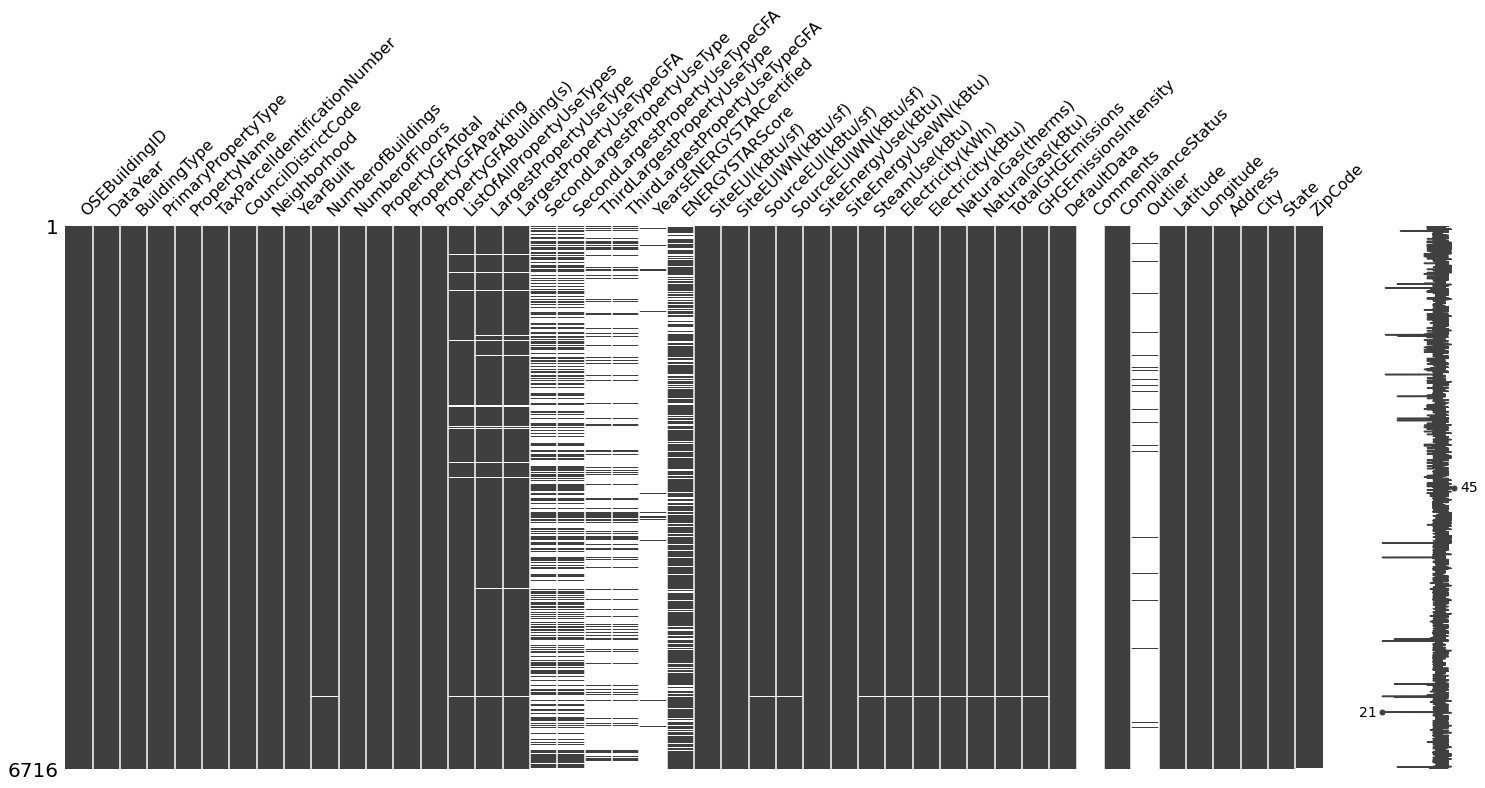

In [32]:
msno.matrix(df)

We see that comments and outlier are empty variables that we'll drop.
Year energy star certification won't be very usefull neither we'll drop it.
The second and third largest property will be kept in a first time.

In [33]:
df.drop(columns=['Comments', 'Outlier', 'YearsENERGYSTARCertified'], inplace=True)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6716 entries, 0 to 6715
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    6716 non-null   int64  
 1   DataYear                         6716 non-null   int64  
 2   BuildingType                     6716 non-null   object 
 3   PrimaryPropertyType              6716 non-null   object 
 4   PropertyName                     6716 non-null   object 
 5   TaxParcelIdentificationNumber    6714 non-null   object 
 6   CouncilDistrictCode              6716 non-null   int64  
 7   Neighborhood                     6716 non-null   object 
 8   YearBuilt                        6716 non-null   int64  
 9   NumberofBuildings                6708 non-null   float64
 10  NumberofFloors                   6708 non-null   float64
 11  PropertyGFATotal                 6716 non-null   int64  
 12  PropertyGFAParking  

> Check duplicated building ID

Each Building are identified by the variable OSEBuildingID. We re going to check first if there are duplicated ID in the dataset.

In [35]:
df[df[['OSEBuildingID', 'DataYear']].duplicated()].shape

(0, 43)

We see no duplicated OSEBuildingID for each year.

> Variables check

We are building here a tab of the variables that we'll keep in our dataset for our prediction.

In [36]:
#function use to check unique values of variables in the dataset
def unique_check(v):
    print(f'The unique values in the variable {v} are : {df[v].unique()}\n')

for e in df.loc[:, 'BuildingType':]:
    unique_check(e)

The unique values in the variable BuildingType are : ['NonResidential' 'Nonresidential COS' 'Multifamily MR (5-9)'
 'SPS-District K-12' 'Multifamily LR (1-4)' 'Campus'
 'Multifamily HR (10+)' 'Nonresidential WA']

The unique values in the variable PrimaryPropertyType are : ['Hotel' 'Other' 'Mid-Rise Multifamily' 'Mixed Use Property' 'K-12 School'
 'College/University' 'Small- and Mid-Sized Office'
 'Self-Storage Facility\n' 'Distribution Center' 'Large Office'
 'Retail Store' 'Low-Rise Multifamily' 'Senior Care Community'
 'Medical Office' 'Hospital' 'Residence Hall/Dormitory'
 'Non-Refrigerated Warehouse' 'Distribution Center\n' 'SPS-District K-12'
 'Worship Facility' 'Supermarket/Grocery Store' 'Laboratory'
 'Self-Storage Facility' 'Refrigerated Warehouse' 'High-Rise Multifamily'
 'Restaurant\n' 'Restaurant' 'University' 'Warehouse' 'Residence Hall'
 'Supermarket / Grocery Store' 'Office']

The unique values in the variable PropertyName are : ['MAYFLOWER PARK HOTEL' 'PARAMOUNT HOTEL'

> Choice of qualitative variables

|   Variables  |   Short description | Comments |  Is dropped  |
|---           |:-:                  |:-:       |:-: 
|   OSEBuildingID   |   Building ID  |   | 
|   DataYear   |   Year of the original dataset  |   |
|   Building Type   |   Type of building by usage | A first level of detail of type of building.
|   PrimaryPropertyType | Type of property  | A second level of detail of type of building
|   Property Name  | Name of the Property   |       |X
|   YearBuilt | Year of construction  |     |
|   NumberofFloors |   |  |
|   PropertyGFATotal |  The gross floor area in square footage in total | Should be the sum of the parking + building
|   PropertyGFAParking | The gross floor area in square footage for parking |   |
|   PropertyGFABuilding(s) | The gross floor area in square footage for buildings |   |
|   ListOfAllPropertyUseTypes | Usage type by list |  |
|   LargestPropertyUseType | Most important type of usage in the building |  |
|   LargestPropertyUseTypeGFA | Gross Floor area of the most important type of usage in the buidling |  |
|   SecondLargestPropertyUseType | Second most important type of usage in the building |  | X
|   SecondLargestPropertyUseTypeGFA | Gross Floor area of the most important type of usage in the buidling |  | X
|   ThirdLargestPropertyUseType | Third most important type of usage in the building |  |X
|   ThirdLargestPropertyUseTypeGFA | Gross Floor area of the third most important type of usage in the buidling |  |X
|   DefaultData | Information if the data are default data or real consumption data |  |X
|   ComplianceStatus |  |  |X
|   Latitude |  |  |
|   Longitude |  |  |
|   Address |  |  |
|   City |  |  |X
|   State |  |  |X
|   ZipCode |  |  |X

> Choice of quantitative variables

|   Variables  |   Short description | Comments |  Is dropped  |
|---           |:-:                  |:-:       |:-: 
|   ENERGYSTARScore   |    |    We'll use this energystarscore during the project  | 
|   SiteEUI(kBtu/sf)    |   Energy use intensity by square feet  |   |
|   SiteEUIWN(kBtu/sf)    |  Energy use intensity by square feet under a normalized whether model |    |  X
|   SourceEUI(kBtu/sf)  | Energy used intensity sourced by square feet  | 
|   SourceEUIWN(kBtu/sf) |  Energy used intensity sourced by square feet under a normalized whether model |     |X
|   SiteEnergyUse(kBtu)   | The use of energy |  |
|   SiteEnergyUseWN(kBtu)  |  The use of energy under a normalized whether model|    |X
|   SteamUse(kBtu)  |   Steam consumption |  |
|   Electricity(kWh)  |  Electricty in KW per hour| Will be dropped to avoid redundancy of information |X
|   Electricity(kBtu)  |  Electricity in KBtu|  |
|   NaturalGas(therms)  |  Gas consumption in therms| Will be dropped to avoid redundancy of information |X
|   NaturalGas(kBtu)  |  Gas consumption in KBtu|  |
|   TotalGHGEmissions  |  |  |
|   GHGEmissionsIntensity   |  GHG emissions by square feet|  |

In [37]:
#drop of the selected variables
dropped_columns = ['NaturalGas(therms)', 'Electricity(kWh)', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)' , 'PropertyName','SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'DefaultData', 'ComplianceStatus', 'City', 'State', 'ZipCode']
df.drop(columns=dropped_columns, inplace=True)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6716 entries, 0 to 6715
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  6716 non-null   int64  
 1   DataYear                       6716 non-null   int64  
 2   BuildingType                   6716 non-null   object 
 3   PrimaryPropertyType            6716 non-null   object 
 4   TaxParcelIdentificationNumber  6714 non-null   object 
 5   CouncilDistrictCode            6716 non-null   int64  
 6   Neighborhood                   6716 non-null   object 
 7   YearBuilt                      6716 non-null   int64  
 8   NumberofBuildings              6708 non-null   float64
 9   NumberofFloors                 6708 non-null   float64
 10  PropertyGFATotal               6716 non-null   int64  
 11  PropertyGFAParking             6716 non-null   int64  
 12  PropertyGFABuilding(s)         6716 non-null   i

> Variables exploration and datacleaning

The project explain clearly that a focus is done on non residential  buildings only, let's check this variable first.

In [39]:
#Building type existing
df['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Multifamily LR (1-4)', 'Campus',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

We have to drop the multifamily Building type.

THe SPS category is Seatle public schools, the others are intellegible.

In [40]:
df = df[~df['BuildingType'].str.contains("Multifamily")]
df['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus', 'Nonresidential WA'], dtype=object)

Let's check after multyfamiliy building type drop what kind of primary property type do we have left.

In [41]:
df['PrimaryPropertyType'].unique()

array(['Hotel', 'Other', 'Mixed Use Property', 'K-12 School',
       'College/University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility\n', 'Distribution Center', 'Large Office',
       'Retail Store', 'Senior Care Community', 'Medical Office',
       'Hospital', 'Residence Hall/Dormitory',
       'Non-Refrigerated Warehouse', 'Distribution Center\n',
       'SPS-District K-12', 'Worship Facility',
       'Supermarket/Grocery Store', 'Laboratory', 'Self-Storage Facility',
       'Refrigerated Warehouse', 'Restaurant\n', 'Low-Rise Multifamily',
       'Restaurant', 'University', 'Warehouse', 'Residence Hall',
       'Supermarket / Grocery Store', 'Office'], dtype=object)

We still have property type like: 'Residence Hall' that could be residential buildings. let's check this

In [42]:
df[df['PrimaryPropertyType'].str.contains('Residence Hall')]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude,Address
115,183,2015,NonResidential,Residence Hall/Dormitory,7443000375,7,MAGNOLIA / QUEEN ANNE,2001,1.0,4.0,139600,37500,102100,Residence Hall/Dormitory,Residence Hall/Dormitory,135520.0,88.0,32.600000,71.500000,4.418055e+06,0.00,2419334.0,1998821.0,123.02,0.81,47.65076266,-122.3638034,362 W EMERSON ST
186,294,2015,NonResidential,Residence Hall/Dormitory,2301950000,7,DOWNTOWN,1913,1.0,9.0,107572,0,107572,"Office, Residence Hall/Dormitory, Retail Store",Residence Hall/Dormitory,63934.0,71.0,53.600000,117.800000,5.445025e+06,2647510.00,2797632.0,0.0,223.86,1.97,47.60775556,-122.3324724,1118 5TH AVE
870,20029,2015,NonResidential,Residence Hall/Dormitory,925049089,4,NORTHEAST,1921,1.0,3.0,21499,0,21499,Residence Hall/Dormitory,Residence Hall/Dormitory,21499.0,91.0,22.100000,69.300000,4.743590e+05,0.00,474378.0,0.0,3.31,0.06,47.66278139,-122.30509963,2111 NE 47TH ST
903,20160,2015,NonResidential,Residence Hall/Dormitory,1321300090,4,NORTHEAST,1930,1.0,3.0,20960,0,20960,Residence Hall/Dormitory,Residence Hall/Dormitory,20960.0,NaN,70.100000,111.700000,1.469870e+06,0.00,382271.0,1087614.0,60.43,2.80,47.66156867,-122.3042914,4510 22ND AVE NE
947,20273,2015,NonResidential,Residence Hall/Dormitory,1142001455,4,NORTHEAST,1993,1.0,3.0,28572,7327,21245,"Parking, Residence Hall/Dormitory",Residence Hall/Dormitory,22000.0,16.0,122.600000,243.800000,2.696136e+06,0.00,1212032.0,1484154.0,87.27,2.87,47.65710843,-122.3140463,4106 BROOKLYN AVE NE
965,20323,2015,NonResidential,Residence Hall/Dormitory,1510600000,3,EAST,1982,1.0,15.0,115775,31535,84240,"Office, Residence Hall/Dormitory",Residence Hall/Dormitory,150000.0,93.0,16.500000,51.900000,2.892428e+06,0.00,2892548.0,0.0,20.16,0.07,47.60804749,-122.32658386,910 MARION ST
1117,20861,2015,NonResidential,Residence Hall/Dormitory,1825049055,4,LAKE UNION,1988,1.0,3.0,21118,0,21118,Residence Hall/Dormitory,Residence Hall/Dormitory,21118.0,39.0,65.900000,145.300000,1.392015e+06,0.00,768718.0,623329.0,38.46,1.66,47.65018106,-122.3442638,3515 WOODLAND PARK AVE N
1220,21262,2015,NonResidential,Residence Hall/Dormitory,1977200720,7,DOWNTOWN,1909,1.0,4.0,29796,0,29796,Residence Hall/Dormitory,Residence Hall/Dormitory,29796.0,39.0,76.900000,141.600000,2.291194e+06,0.00,867819.0,1423411.0,81.65,2.61,47.61273575,-122.34406281,2119 2ND AVE
1765,23297,2015,NonResidential,Residence Hall/Dormitory,8590900085,3,EAST,1904,1.0,1.0,44086,0,44086,Residence Hall/Dormitory,Residence Hall/Dormitory,44091.0,31.0,74.400000,140.800000,3.282191e+06,1709038.00,1196273.0,376930.0,160.28,3.52,47.60733516,-122.3257991,804 9TH AVE
2573,26017,2015,NonResidential,Residence Hall/Dormitory,9301301410,7,MAGNOLIA / QUEEN ANNE,1981,1.0,4.0,23513,2211,21302,"Office, Parking, Residence Hall/Dormitory, Res...",Residence Hall/Dormitory,15200.0,NaN,93.500000,197.100000,1.991174e+06,0.00,1009043.0,982173.0,59.20,2.33,47.63659994,-122.3442026,1911 AURORA AVE N


We see that those buildings could be consider as Residential buildings. They are actually student dormitory. We ll drop them and will consider them as residential buildings.

In [43]:
#drop
df = df[~df['PrimaryPropertyType'].str.contains('Residence Hall')]

#check
df[df['PrimaryPropertyType'].str.contains('Residence Hall')]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude,Address


We see that the variable NUmberof Buildings contains NaN and 0 values let's check this.

In [44]:
df[df['NumberofBuildings'].isin([np.nan, 0])].shape

(53, 28)

We won t try to guess the number of buildings of those entries so we'll drop them from our dataset.

In [45]:
#replace
df = df[~df['NumberofBuildings'].isin([np.nan, 0])]

#check
df[df['NumberofBuildings'].isin([np.nan, 0])]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude,Address


The variable number of floors contains NaN let's check those entries.

In [46]:
df[df['NumberofFloors'].isin([np.nan])].shape

(8, 28)

We'll drop them as well as we're not going to guess anything here.

In [47]:
#replace
df = df[~df['NumberofFloors'].isin([np.nan])]

#check
df[df['NumberofFloors'].isin([np.nan])]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude,Address


We re about to check the property GFA. We have one variable total that should be the sum of the two others : building and parking.

In [48]:
df['GFA SUM TEST'] = df['PropertyGFATotal'] - df['PropertyGFAParking'] - df['PropertyGFABuilding(s)']

In [49]:
df[df['GFA SUM TEST'] != 0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude,Address,GFA SUM TEST


In [50]:
df.drop(columns={'GFA SUM TEST'}, inplace = True)

We are going to check the largestpropertyusetype variable to be sure that we have no residentials building referenced

In [51]:
df['LargestPropertyUseType'].unique()

array(['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly',
       nan, 'Library', 'Fitness Center/Health Club/Gym',
       'Social/Meeting Hall', 'Courthouse', 'Other', 'K-12 School',
       'College/University', 'Automobile Dealership', 'Office',
       'Self-Storage Facility', 'Retail Store', 'Senior Care Community',
       'Medical Office', 'Hospital (General Medical & Surgical)',
       'Museum', 'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Other/Specialty Hospital',
       'Financial Office', 'Non-Refrigerated Warehouse',
       'Distribution Center', 'Parking', 'Multifamily Housing',
       'Worship Facility', 'Laboratory', 'Supermarket/Grocery Store',
       'Convention Center', 'Urgent Care/Clinic/Other Outpatient',
       'Other - Services', 'Strip Mall', 'Wholesale Club/Supercenter',
       'Refrigerated Warehouse', 'Other - Recreation', 'Lifestyle Center',
       'Other - Public Services', 'Data Center', 'Other - M

We see that we have still two type that could be residentials buildings

Multifamily Housing and Residence Hall/Dormitory'.

Let's check this.

In [52]:
df[df['LargestPropertyUseType'].isin(['Multifamily Housing', 'Residence Hall/Dormitory'])]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude,Address
163,264,2015,NonResidential,Mixed Use Property,8681450000,7,MAGNOLIA / QUEEN ANNE,2002,1.0,4.0,110785,39179,71606,"Financial Office, Multifamily Housing, Parking...",Multifamily Housing,58563.0,NaN,95.800000,293.500000,1.060879e+07,0.0,10228437.0,380776.0,91.53,0.43,47.62392426,-122.35764313,516 1ST AVE W
1170,21122,2015,NonResidential,Mixed Use Property,1972202755,6,LAKE UNION,2001,1.0,3.0,41827,9226,32601,"Multifamily Housing, Office, Other - Mall, Par...",Multifamily Housing,14273.0,NaN,101.600000,231.500000,4.248084e+06,0.0,2499034.0,1749154.0,110.32,2.38,47.65018452,-122.3493482,3420 FREMONT AVE N
1311,21481,2015,Campus,Low-Rise Multifamily,1976200210,7,DOWNTOWN,1942,1.0,4.0,45500,0,45500,"Bar/Nightclub, Food Sales, Multifamily Housing...",Multifamily Housing,22669.0,NaN,87.100000,273.600000,3.863772e+06,0.0,3863933.0,0.0,26.94,0.23,47.60921881,-122.3408095,1513 1ST AVE
1858,23562,2015,NonResidential,Mixed Use Property,8670450000,7,DOWNTOWN,1913,1.0,3.0,43878,0,43878,"Multifamily Housing, Non-Refrigerated Warehous...",Multifamily Housing,12000.0,NaN,22.500000,70.700000,7.396620e+05,0.0,739692.0,0.0,5.16,0.04,47.60180041,-122.33520381,80 YESLER WAY
2341,25222,2015,NonResidential,Mixed Use Property,6364000000,7,DOWNTOWN,2009,1.0,39.0,1074552,112124,962428,"Hotel, Multifamily Housing, Parking",Multifamily Housing,311521.0,62.0,44.400000,118.500000,2.727354e+07,0.0,21129882.0,6144534.0,473.63,0.36,47.61356354,-122.33405304,737 OLIVE WAY
2422,25522,2015,NonResidential,Mixed Use Property,9191201460,4,NORTHEAST,1997,1.0,4.0,32282,6985,25297,"Multifamily Housing, Office, Other, Parking",Multifamily Housing,12600.0,NaN,57.200000,133.900000,1.446455e+06,0.0,893992.0,552500.0,35.58,0.98,47.66821286,-122.2998974,5401 26TH AVE NE
2435,25546,2015,NonResidential,Mixed Use Property,5247800080,7,DOWNTOWN,2005,1.0,5.0,57600,8000,49600,"Financial Office, Multifamily Housing, Parking...",Residence Hall/Dormitory,27600.0,NaN,141.800000,285.000000,7.175646e+06,0.0,3294193.0,3881589.0,229.12,3.73,47.6004814,-122.3351416,210 ALASKAN WAY S
2481,25674,2015,NonResidential,Low-Rise Multifamily,6003500480,3,EAST,1910,1.0,3.0,32100,0,32100,"Bar/Nightclub, Multifamily Housing",Multifamily Housing,21400.0,NaN,2.900000,3.500000,9.385100e+04,0.0,6581.0,87270.0,4.68,0.14,47.61432913,-122.3197623,916 E PIKE ST
2781,26834,2015,NonResidential,Mixed Use Property,5247801900,2,DOWNTOWN,1909,1.0,3.0,20620,0,20620,"Multifamily Housing, Retail Store, Social/Meet...",Multifamily Housing,10060.0,NaN,46.000000,91.600000,9.475340e+05,0.0,427886.0,519666.0,30.58,1.39,47.59768677,-122.32537842,525 MAYNARD AVE S
3042,27838,2015,NonResidential,Mixed Use Property,7234600515,3,EAST,1998,1.0,5.0,53034,14625,38409,"Multifamily Housing, Parking, Supermarket/Groc...",Multifamily Housing,22486.0,94.0,89.800000,213.400000,3.299335e+06,0.0,2093492.0,1205930.0,78.64,1.31,47.61547934,-122.3110575,1600 E MADISON ST


Those are mixed type of usage but the largest property use type is residentials so we'll drop those entries.

In [53]:
#drop
df = df[~df['LargestPropertyUseType'].isin(['Multifamily Housing', 'Residence Hall/Dormitory'])]

#check
df[df['LargestPropertyUseType'].isin(['Multifamily Housing', 'Residence Hall/Dormitory'])]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude,Address


Now we'll explore the quantitative variables as univariate analysis to have a representation of the different distributions.

In [54]:
df.describe()

,OSEBuildingID,DataYear,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,3197.000000,3197.000000,3197.000000,3197.000000,3197.000000,3197.000000,3.197000e+03,3197.000000,3.197000e+03,3.128000e+03,2146.000000,3189.000000,3190.000000,3.190000e+03,3.190000e+03,3.190000e+03,3.190000e+03,3190.000000,3190.000000
mean,15708.021270,2015.494839,4.363153,1961.591492,1.131999,4.118236,1.159942e+05,13471.075070,1.025232e+05,9.600696e+04,64.920783,71.431828,175.484514,8.124813e+06,5.038884e+05,5.683948e+06,1.872318e+06,177.957166,1.463972
std,13311.139965,0.500052,2.204315,32.537379,2.247255,6.593634,2.530017e+05,44109.119502,2.357763e+05,2.304522e+05,28.597492,72.199862,181.996188,2.563460e+07,5.315331e+06,1.766005e+07,8.014867e+06,676.939617,2.184709
min,1.000000,2015.000000,1.000000,1900.000000,1.000000,0.000000,1.128500e+04,-2.000000,-5.055000e+04,5.656000e+03,1.000000,0.000000,-2.000000,0.000000e+00,0.000000e+00,-1.154170e+05,0.000000e+00,-0.800000,-0.020000
25%,572.000000,2015.000000,2.000000,1930.000000,1.000000,1.000000,2.963600e+04,0.000000,2.858600e+04,2.562000e+04,48.000000,33.200000,75.925001,1.214191e+06,0.000000e+00,7.176935e+05,0.000000e+00,19.522500,0.270000
50%,21088.000000,2015.000000,4.000000,1965.000000,1.000000,2.000000,4.929900e+04,0.000000,4.760200e+04,4.349500e+04,73.000000,51.500000,130.899994,2.502106e+06,0.000000e+00,1.621417e+06,4.693920e+05,48.695000,0.760000
75%,24479.000000,2016.000000,7.000000,1989.000000,1.000000,4.000000,1.047860e+05,0.000000,9.447000e+04,9.000000e+04,89.000000,81.400000,204.075005,6.963231e+06,0.000000e+00,4.897172e+06,1.445444e+06,138.937500,1.720000
max,50226.000000,2016.000000,7.000000,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,100.000000,834.400024,2620.000000,8.739237e+08,1.349435e+08,6.570744e+08,2.979090e+08,16870.980000,34.090000


We see that three variables have negative values so we'll drop those entries because they are total non-sense.

In [55]:
df = df.loc[(df['PropertyGFAParking']>=0) & (df['SourceEUI(kBtu/sf)']>=0) & (df['TotalGHGEmissions']>=0)]
df.shape

(3187, 28)

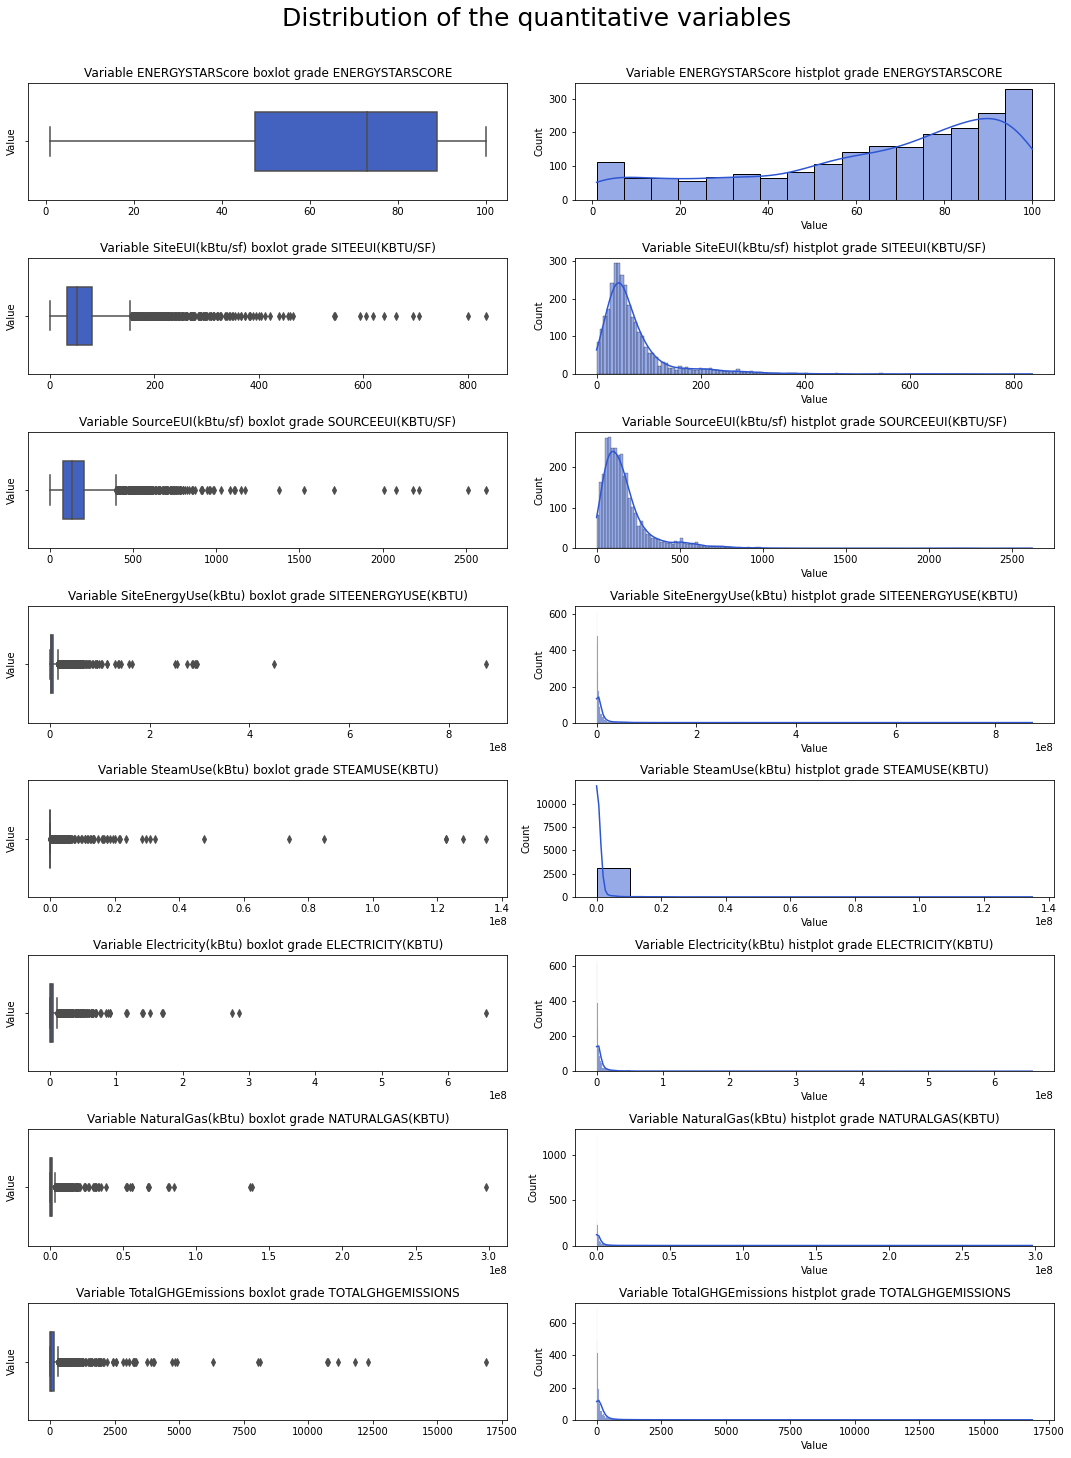

In [56]:
ploting_distirbution(df, df.loc[:, 'ENERGYSTARScore': 'TotalGHGEmissions'].columns)

We see here some high outliers values are existing. Let's decide later how to deal with them.

# Traitement des valeurs manquantes


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3187 entries, 0 to 6715
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  3187 non-null   int64  
 1   DataYear                       3187 non-null   int64  
 2   BuildingType                   3187 non-null   object 
 3   PrimaryPropertyType            3187 non-null   object 
 4   TaxParcelIdentificationNumber  3187 non-null   object 
 5   CouncilDistrictCode            3187 non-null   int64  
 6   Neighborhood                   3187 non-null   object 
 7   YearBuilt                      3187 non-null   int64  
 8   NumberofBuildings              3187 non-null   float64
 9   NumberofFloors                 3187 non-null   float64
 10  PropertyGFATotal               3187 non-null   int64  
 11  PropertyGFAParking             3187 non-null   int64  
 12  PropertyGFABuilding(s)         3187 non-null   i

We see that for some entries the quantitative variables related to the energy consumption are missing.

In [58]:
df[df['SiteEUI(kBtu/sf)'].isna()]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude,Address
3644,435,2016,NonResidential,Other,1978200105,7,DOWNTOWN,1990,1.0,6.0,1400000,0,1400000,"Convention Center, Parking",Convention Center,1072000.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.61195,-122.33167,705 Pike St


We'll drop those NaN lines as they are not numbered. Another solutions would have been to replace the NaN using an univariate or multivariate replacement methods. 

I do prefer to drop the lines because we won't use the consumptions variable in the future for prediction as mentionned in the mission brief. It is better to perform feature eng. on pure figures coming from the source.


In [59]:
#replacement
df = df[~df['SiteEUI(kBtu/sf)'].isna()]

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3186 entries, 0 to 6715
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  3186 non-null   int64  
 1   DataYear                       3186 non-null   int64  
 2   BuildingType                   3186 non-null   object 
 3   PrimaryPropertyType            3186 non-null   object 
 4   TaxParcelIdentificationNumber  3186 non-null   object 
 5   CouncilDistrictCode            3186 non-null   int64  
 6   Neighborhood                   3186 non-null   object 
 7   YearBuilt                      3186 non-null   int64  
 8   NumberofBuildings              3186 non-null   float64
 9   NumberofFloors                 3186 non-null   float64
 10  PropertyGFATotal               3186 non-null   int64  
 11  PropertyGFAParking             3186 non-null   int64  
 12  PropertyGFABuilding(s)         3186 non-null   i

# Data exploration

Text(0.5, 0, 'Value')

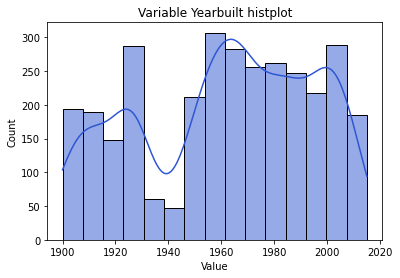

In [61]:
#datayear distribution
sns.histplot(x=df['YearBuilt'], kde=True, color='#2E56D3')
plt.title(f'Variable Yearbuilt histplot')
plt.xlabel('Value')

Everything looks ok. The period 1930-1950 shows very low quantity of Building built explain by the 2WW.

Text(0.5, 0, 'Value')

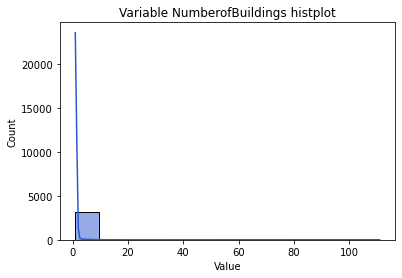

In [62]:
#NumberofBuildings  distribution
sns.histplot(x=df['NumberofBuildings'], kde=True, color='#2E56D3')
plt.title(f'Variable NumberofBuildings histplot')
plt.xlabel('Value')

Text(0.5, 0, '')

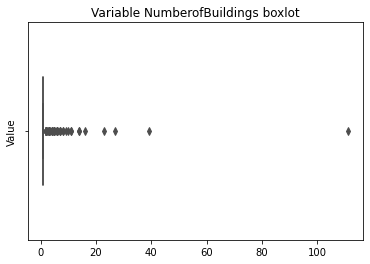

In [63]:
sns.boxplot(x=df['NumberofBuildings'], width=0.5, color='#2E56D3')
plt.title(f'Variable NumberofBuildings boxlot')
plt.ylabel('Value')
plt.xlabel('')

In [64]:
df['NumberofBuildings'].describe()

count    3186.000000
mean        1.132454
std         2.251119
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       111.000000
Name: NumberofBuildings, dtype: float64

We see that we have a majority of 1 Building by id entries, but some of them have more than one building. That could be explained by some kind of building campus.

Anyway, as far as complex campus include information of several buildings whithout being able to know the repartition of consumption between them, I decide to drop the buildings with number of buildings >1

In [65]:
df[df['NumberofBuildings']>1]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude,Address
35,46,2015,NonResidential,Distribution Center,323049024,2,GREATER DUWAMISH,1961,7.0,2.0,714095,0,714095,NaN,NaN,NaN,1.0,66.900000,210.000000,47843892.0,0.0,47845869.0,0.0,333.54,0.18,47.5106034,-122.29027588,3301 S NORFOLK ST
127,211,2015,Campus,College/University,3226049021,5,NORTHWEST,1970,11.0,2.0,694072,111625,582447,College/University,College/University,667265.0,NaN,55.600000,162.300000,37117212.0,0.0,33183593.0,3934997.0,440.31,0.43,47.69879162,-122.3338342,9600 COLLEGE WAY N
161,261,2015,Campus,Large Office,7883608601,1,GREATER DUWAMISH,1980,16.0,2.0,334368,31874,302494,"Laboratory, Office, Parking",Office,260000.0,NaN,154.500000,439.300000,52273792.0,0.0,44866796.0,7408855.0,706.26,1.53,47.52440204,-122.3115544,1420 S TRENTON ST
195,315,2015,Campus,Other,7666202325,7,DOWNTOWN,1995,4.0,3.0,215476,0,215476,Other,Other,217088.0,NaN,116.900000,266.400000,25377650.0,0.0,14917481.0,10460791.0,659.56,2.76,47.61120625,-122.34849684,2201 ALASKAN WAY
341,477,2015,Campus,Other,1984200455,3,LAKE UNION,1997,3.0,5.0,535947,195283,340664,"Other, Parking",Other,535947.0,NaN,254.200000,536.600000,136241424.0,0.0,69147767.0,67096519.0,4045.53,6.99,47.6286355,-122.3306365,1100 FAIRVIEW AVE N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6476,40447,2016,Nonresidential COS,Mixed Use Property,7666203010,2,GREATER DUWAMISH,1966,5.0,1.0,87458,0,87458,"Data Center, Distribution Center, Office, Other",Office,41097.0,NaN,96.900002,194.699997,8475238.0,0.0,3890327.0,4584911.0,270.63,3.09,47.57918,-122.32075,2700 Airport Way S
6508,49705,2016,Nonresidential COS,Other,0225049062,4,NORTHEAST,1929,8.0,0.0,502030,0,502030,Other - Recreation,Other - Recreation,564258.0,NaN,32.700001,69.000000,18470340.0,0.0,9359884.0,9110455.0,549.11,1.09,47.68212,-122.2633,7400 Sand Point Way NE
6518,49718,2016,Nonresidential COS,Other,2924049006,1,GREATER DUWAMISH,2012,2.0,2.0,137138,0,137138,Other - Utility,Other - Utility,138602.0,NaN,39.500000,124.000000,5475367.0,0.0,5475366.0,0.0,38.17,0.28,47.53246,-122.33304,130 South Kenyon St.
6592,49909,2016,Campus,University,0001800137,2,GREATER DUWAMISH,2007,4.0,2.0,149856,0,149856,College/University,College/University,149856.0,NaN,42.299999,113.699997,6335315.5,0.0,4967236.0,1368079.0,107.29,0.72,47.54193,-122.32404,6770 E. Marginal Way S.


In [66]:
df = df[df['NumberofBuildings']== 1]
df.drop(columns={'NumberofBuildings'}, inplace = True)

Text(0.5, 0, 'Value')

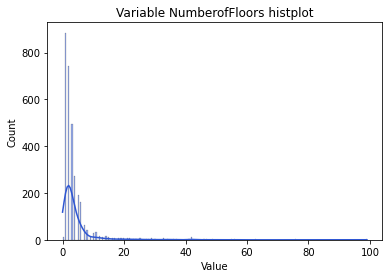

In [67]:
#Number of floors distribution
sns.histplot(x=df['NumberofFloors'], kde=True, color='#2E56D3')
plt.title(f'Variable NumberofFloors histplot')
plt.xlabel('Value')

Text(0.5, 0, '')

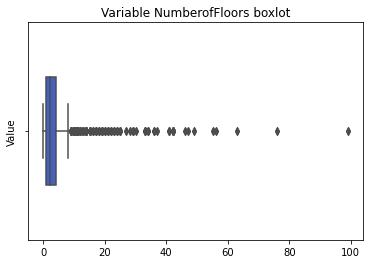

In [68]:
sns.boxplot(x=df['NumberofFloors'], width=0.5, color='#2E56D3')
plt.title(f'Variable NumberofFloors boxlot')
plt.ylabel('Value')
plt.xlabel('')

Here we see that we have a majority of 0 to 10 max floors. Some outliers lead to 20 to 100 floors. Let's check these entries.

In [69]:
df[df['NumberofFloors']>50]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude,Address
235,357,2015,Nonresidential COS,Large Office,942000720,3,DOWNTOWN,1990,63.0,1195387,159600,1035787,"Office, Other, Parking",Office,1187924.0,82.0,53.600000,168.400000,6.471565e+07,0.000,64696526.0,21804.0,452.16,0.15,47.60491077,-122.32891587,700 5TH AVE
271,399,2015,NonResidential,Large Office,1974700120,7,DOWNTOWN,1988,55.0,1400000,285000,1115000,"Office, Other, Parking, Restaurant",Office,1021940.0,94.0,44.700000,134.200000,5.162555e+07,1923581.000,48086118.0,1617830.0,569.61,0.26,47.60722258,-122.3361529,1201 3RD AVE
293,422,2015,NonResidential,Large Office,1976700125,7,DOWNTOWN,1989,56.0,1605578,389860,1215718,"Office, Other, Parking",Office,1314475.0,97.0,35.900000,108.000000,4.834256e+07,595133.000,45187640.0,2561662.0,496.99,0.19,47.61001362,-122.3323936,601 UNION ST
581,775,2015,NonResidential,Large Office,942000640,7,DOWNTOWN,1985,76.0,1952220,319400,1632820,"Office, Parking",Office,1680937.0,84.0,56.300000,171.900000,9.456009e+07,0.000,90754881.0,3808965.0,834.96,0.23,47.60466039,-122.33028619,701 5TH AVE
1371,21611,2015,NonResidential,Worship Facility,2124049098,2,GREATER DUWAMISH,1977,99.0,21948,0,21948,Worship Facility,Worship Facility,21948.0,54.0,14.500000,45.500000,3.182050e+05,0.000,318218.0,0.0,2.22,0.04,47.55057128,-122.302943,5801 BEACON AVE S
3573,357,2016,Nonresidential COS,Large Office,0942000720,3,DOWNTOWN,1990,63.0,1354987,159600,1195387,"Office, Parking",Office,1191115.0,89.0,50.400002,158.100006,6.157618e+07,0.000,61576180.0,0.0,429.27,0.32,47.60501,-122.32988,700 Fifth Avenue
3611,399,2016,NonResidential,Large Office,1974700120,7,DOWNTOWN,1988,55.0,1400000,285000,1115000,"Office, Other, Parking, Restaurant",Office,994116.0,92.0,46.700001,140.199997,5.307916e+07,2179487.750,49472833.0,1426840.0,588.90,0.42,47.60723,-122.33611,1201 3rd ave
3632,422,2016,NonResidential,Large Office,1976700125,7,DOWNTOWN,1989,56.0,1605578,389860,1215718,"Office, Other, Parking",Office,1314475.0,97.0,36.799999,110.300003,4.951770e+07,915654.875,46081813.0,2520230.0,525.78,0.33,47.61043,-122.33206,601 Union St.
3899,775,2016,NonResidential,Large Office,0942000640,7,DOWNTOWN,1985,76.0,1952220,319400,1632820,"Office, Parking",Office,1680937.0,86.0,55.299999,167.300003,9.293764e+07,0.000,87851862.0,5085763.0,882.56,0.45,47.60454,-122.33072,701 5th Avenue
4699,21611,2016,NonResidential,Worship Facility,2124049098,2,GREATER DUWAMISH,1977,99.0,21948,0,21948,Worship Facility,Worship Facility,21948.0,80.0,14.900000,46.599998,3.260012e+05,0.000,326001.0,0.0,2.27,0.10,47.55072,-122.30265,5801 Beacon Avenue South


The columbia center, is the the building with the largest number of floors in seatle and it represents a total of 76 floors.

We'll drop the outliers havuing more than 76 floors.

There are two outliers which are Worship facilities so we confirm that we can drop them.

In [70]:
df = df[df['NumberofFloors']<=76]

Text(0.5, 0, 'Value')

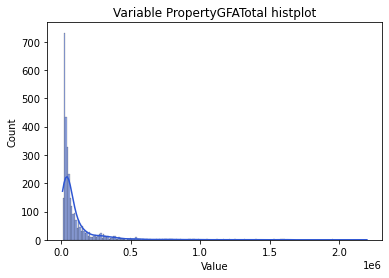

In [71]:
#NProperty GFA distribution
sns.histplot(x=df['PropertyGFATotal'], kde=True, color='#2E56D3')
plt.title(f'Variable PropertyGFATotal histplot')
plt.xlabel('Value')

Text(0.5, 0, '')

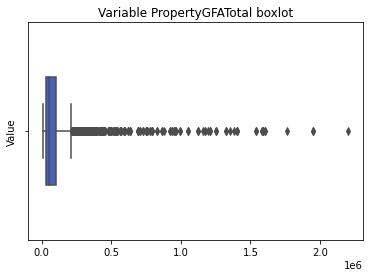

In [72]:
sns.boxplot(x=df['PropertyGFATotal'], width=0.5, color='#2E56D3')
plt.title(f'Variable PropertyGFATotal boxlot')
plt.ylabel('Value')
plt.xlabel('')

> Energyuse variables

In [73]:
df.loc[:, 'SiteEUI(kBtu/sf)': 'GHGEmissionsIntensity'].describe()

,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,3121.000000,3121.000000,3.121000e+03,3.121000e+03,3.121000e+03,3.121000e+03,3121.000000,3121.000000
mean,71.050144,174.943063,7.281782e+06,4.026469e+05,5.183103e+06,1.675300e+06,156.187321,1.441359
std,72.303266,182.774146,1.810130e+07,3.999642e+06,1.247440e+07,7.095919e+06,543.211259,2.166698
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,33.099998,75.600000,1.200811e+06,0.000000e+00,7.149390e+05,0.000000e+00,19.160000,0.270000
50%,51.100000,130.300000,2.465984e+06,0.000000e+00,1.598455e+06,4.528440e+05,47.940000,0.750000
75%,80.800000,203.300000,6.797647e+06,0.000000e+00,4.788414e+06,1.402659e+06,134.800000,1.700000
max,834.400024,2620.000000,4.483853e+08,1.278697e+08,2.847263e+08,2.979090e+08,16870.980000,34.090000


We see some negative values that we'll drop

In [74]:
df = df[df['SourceEUI(kBtu/sf)']>=0]

df = df[df['Electricity(kBtu)']>=0]

df = df[df['TotalGHGEmissions']>=0]

df = df[df['GHGEmissionsIntensity']>=0]

> Correlation analysis

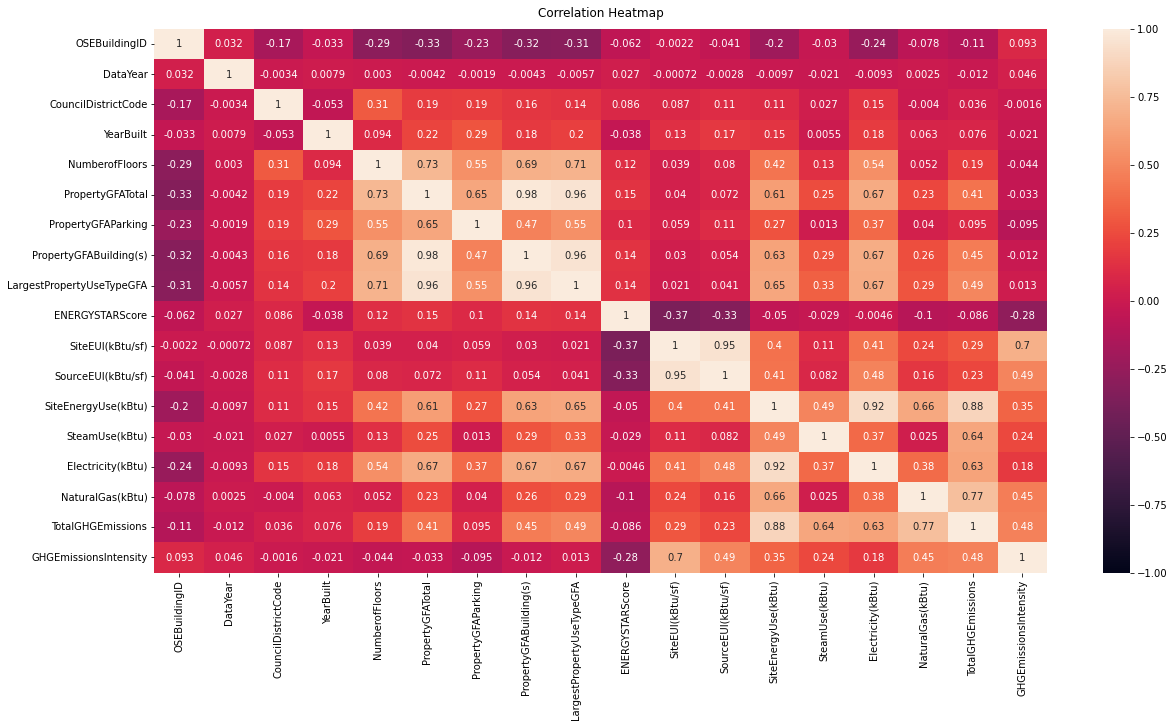

In [75]:
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

We see that SiteEUI is a variable that is strongly correlated (linerarly) with the electricvity consumtions (0.95 pearson r coeff) and with the GHG consumpetions. Also, steam and gas are two highly correlated variables with SiteEUI.

The variable GHG emission is as well strongly correlated, with the others variables consumptions than SiteEUI.

The GFA is strongly correlated with the consumptions as well and we see that the building part is a lot more correlated than the parking part which is fine.

We'll drop the GFA variables that are correlated. They re 3 we'll keep only one.

In [76]:
#droping correlated features
df.drop(columns = ['PropertyGFATotal', 'LargestPropertyUseTypeGFA', 'PropertyGFAParking'], inplace=True)

> Choice of the target variables for our models 

At this stage we can choose our targerted variables that we will try to predict with our models.

All the variables expressed as intensity are consumption based variables compared to their activity (GDP or other metrics). My choice is to keep those intensity variables for challenging energy star score but won't be used directly in the feature engineering as we will prefer real consumptions.

The site energy used contains the same information than the following variables:
* Electricity
* NaturalGas
* SteamUse

The source EUI is a metrics takling about the total amount of energy to run the building. Which is an interesting information but for our purpose we'll focus on the real consumption and not on the potential consumption of the analysed years.

The energystarscore is a score calculated according to the physical attributes of the buildings, its operations, how the energy is used etc. This variable allow us to have a score that can compare two buildings in terms of energy even if they doesn t have the same purpose, the same operational levels etc

Our targets will be the SIteEnergyYse and the TOtalGHG emissions.

The Energystar score will be tested and we'll see if we can use it in our model.

The intensity variables will be kept as they will help us challenging the energy star score.

> ACP

We are going to perform an ACP to visualize the global inertia repartition between variables and check if we can grab some more information from it.

In [77]:
#ranking population
df_pca = df.copy()
df_pca = df_pca[['YearBuilt', 'NumberofFloors', 'PropertyGFABuilding(s)', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity']]

In [78]:
#number components
n_comp = 6

#selecting columns, droping total population as there are too much gap between some countries it will generate itself a huge part of the inertia
data_pca = df_pca.values
features = df_pca.columns

In [79]:
# Centering and reducting
std_scale = StandardScaler().fit(data_pca)
X_scaled = std_scale.transform(data_pca)

In [80]:
# principal composent calculus
pca = PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=6)

In [81]:
#function display circle plot
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(), c="red", marker='o')
    plt.xlabel("Inertia rank")
    plt.ylabel("Inertia %")
    plt.title("Inertia by axis")
    plt.show(block=False)

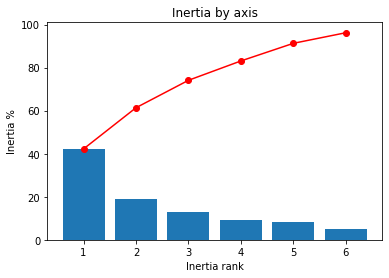

In [82]:
# Percentage of Variance (Information) for each by PC
display_scree_plot(pca)

In [83]:
#function corr circle
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:  # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7, 6))

            # détermination des limites du graphique
            if lims is not None:
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30:
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else:
                xmin, xmax, ymin, ymax = min(pcs[d1, :]), max(
                    pcs[d1, :]), min(pcs[d2, :]), max(pcs[d2, :])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30:
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                           pcs[d1, :], pcs[d2, :],
                           angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0, 0], [x, y]] for x, y in pcs[[d1, d2]].T]
                ax.add_collection(LineCollection(
                    lines, axes=ax, alpha=.1, color='black'))

            # affichage des noms des variables
            if labels is not None:
                for i, (x, y) in enumerate(pcs[[d1, d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax:
                        plt.text(x, y, labels[i], fontsize='14', ha='center',
                                 va='center', rotation=label_rotation, color="blue", alpha=0.5)

            # affichage du cercle
            circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)

            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(
                d1+1, round(100*pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('F{} ({}%)'.format(
                d2+1, round(100*pca.explained_variance_ratio_[d2], 1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

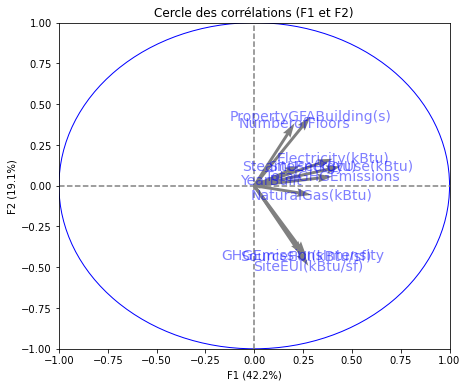

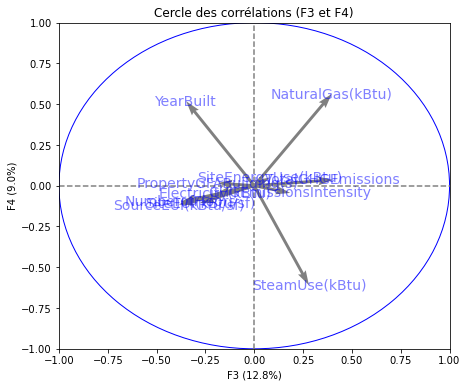

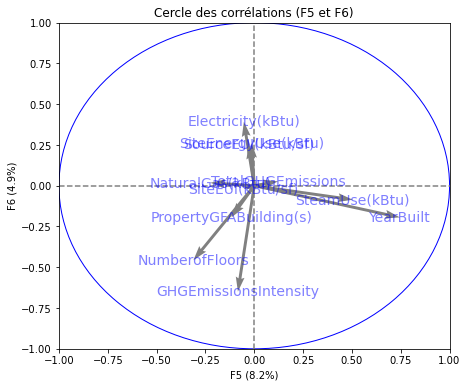

In [84]:
# corr circles
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

The ACP doesnt' bring as much information as expected.

> Map of the buildings

In [85]:
df['Latitude'] = df['Latitude'].astype(float)
df['Longitude'] = df['Longitude'].astype(float)

In [86]:
df['SiteEnergyUse(kBtu)'].describe()

count    3.121000e+03
mean     7.281782e+06
std      1.810130e+07
min      0.000000e+00
25%      1.200811e+06
50%      2.465984e+06
75%      6.797647e+06
max      4.483853e+08
Name: SiteEnergyUse(kBtu), dtype: float64

In [87]:
df['TotalGHGEmissions'].describe()

count     3121.000000
mean       156.187321
std        543.211259
min          0.000000
25%         19.160000
50%         47.940000
75%        134.800000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64

In [88]:
fig = px.scatter(df, x="Longitude", y="Latitude", color="SiteEnergyUse(kBtu)", width = 600, height=600, title="Seatle's building maps colored by Site energy used", range_color=(0,10000000))
fig.update_traces(textposition="bottom right")
fig.update_layout()
fig.show()

In [89]:
fig = px.scatter(df, x="Longitude", y="Latitude", color="TotalGHGEmissions", width = 600, height=600, title="Seatle's building maps colored by GHG emissions", range_color=(0,140))
fig.update_traces(textposition="bottom right")
fig.update_layout()
fig.show()

In [90]:
fig = px.scatter(df, x="Longitude", y="Latitude", color="ENERGYSTARScore", width = 600, height=600, title="Seatle's building maps colored by Energy star score")
fig.update_traces(textposition="bottom right")
fig.update_layout()
fig.show()

In [91]:
fig = px.scatter(df, x="Longitude", y="Latitude", color="YearBuilt", width = 600, height=600, title="Seatle's building maps colored by YearBuilt")
fig.update_traces(textposition="bottom right")
fig.update_layout()
fig.show()

We see that the building map of Seatle shows a high concentration of high consumption building and high GHG emissions building in the center of the map.

The energy star score shows a different vision as it seems that the score are equaly spread all over the map.

Let's check if Address can help us locate some level of consumptions.

We see that we have a massive quantity of old buildings in the center of the map where the consumptions are at their highest rank.



In [92]:
#checking address
len(df['Address'].unique())

2944

Too much address to compute to check a relative link between location and consumptions.

Looking for a link between the kind of street(avenue, street etc) doesn't look like something very interesting for our analysis.

I choose to use the lattitude and longitude as continuous variable for our regression.

# Feature engineering<a class="anchor" id="feature_eng"></a>

We have to be able to predict the consumption but we can't predict on the figures basis.

We have to perform some feature engineering to do so.

First we'll check by bins of lattitude and longitude as expressed earlier.

## A- Building age calculation

We will use the age of the building at the date of the consumption statement

In [93]:
df['BuildingAge'] = df['DataYear'] - df['YearBuilt']
df.drop(columns=['YearBuilt'], inplace=True) #keeping datayear for later drop building ID duplicates

## B- SourceEUI drop

We'll keep Site EUI and drop source eui. The source EUI being the total energy for the building to work but the real consumption would be more accurate.

In [94]:
df.drop(columns={'SourceEUI(kBtu/sf)'}, inplace=True)

# C- Address & Location

We re going to look at the consumptions distributions at a same place (same street, way, avenue).

To do so we need to consider only the text after the first space.

In [95]:
df[['to_drop','Location']] = df["Address"].str.split(" ", 1, expand=True)
df['Location'] = df['Location'].str.replace(" ","")

The marjority of location have only one or two buildings referenced. Some outliers contain over 2 buildings to 81.

In [96]:
df['Location'].value_counts().describe()

count    1300.000000
mean        2.400769
std         4.153724
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        80.000000
Name: Location, dtype: float64

<AxesSubplot:xlabel='Location'>

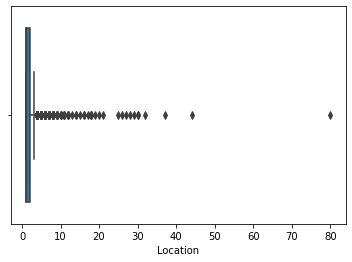

In [97]:
sns.boxplot(x=df['Location'].value_counts())

In [98]:
#checking the type of way
df['Address']

0          405 OLIVE WAY
1            724 PINE ST
2           1900 5TH AVE
3         620 STEWART ST
4          401 LENORA ST
              ...       
6711    1600 S Dakota St
6712       719 8th Ave S
6713      1920 1st Ave W
6714      8319 8th Ave S
6715    2820 S Myrtle St
Name: Address, Length: 3121, dtype: object

> Checking distribution by type of way

In [99]:
# type_of_way creation
df['type_of_way'] = df['Address'].apply(way_type_extraction)

In [100]:
#check
df['type_of_way'].unique()

array(['WAY', 'STREET', 'AVENUE', 'other'], dtype=object)

In [101]:
df[df['type_of_way']=='other'].shape

(104, 26)

Only 109 lines in 'other' category which is great.

Let's check the result of the consumptions by type of way.

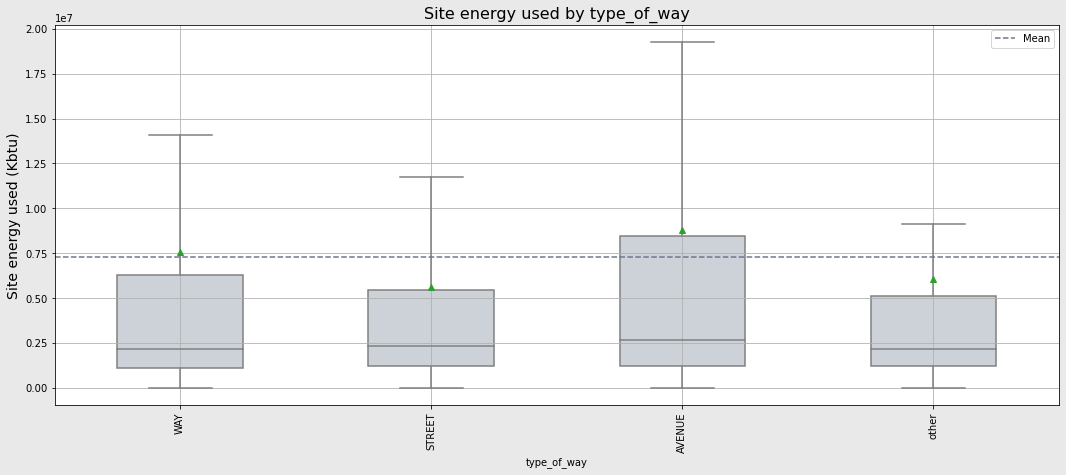

In [102]:
visualisation_eui('type_of_way', df)

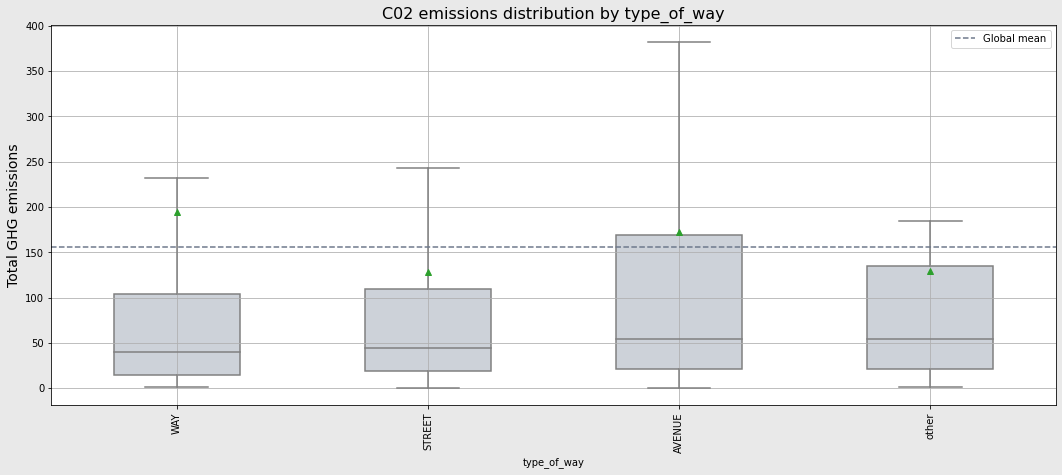

In [103]:
visualisation_ghg('type_of_way', df)

It seems that the distributions are not that different wether we considerthe type of way.

We see high level of outliers but difficult to interpret by kind of way the consumptions here. 

We won't use this newly created variable for our model.

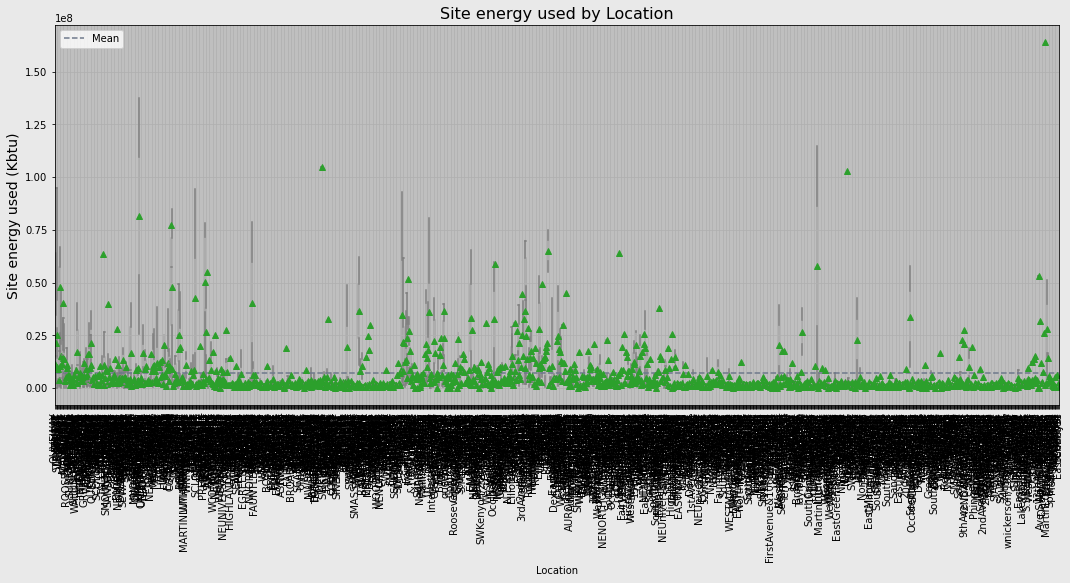

In [104]:
visualisation_eui('Location', df)

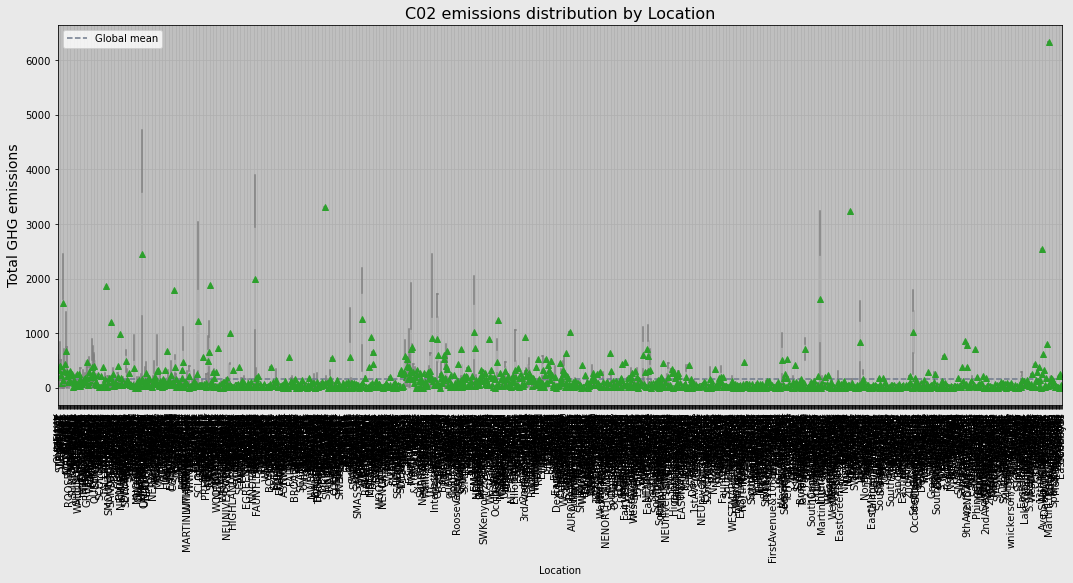

In [105]:
visualisation_ghg('Location', df)

We can't use the type of way newly created variable as the distributions are not the same. We'll keep location for one hot encoder.

In [106]:
df.drop(columns={'to_drop', 'Address', 'type_of_way'}, inplace=True)

> Checking distribution of buildings consumption by district

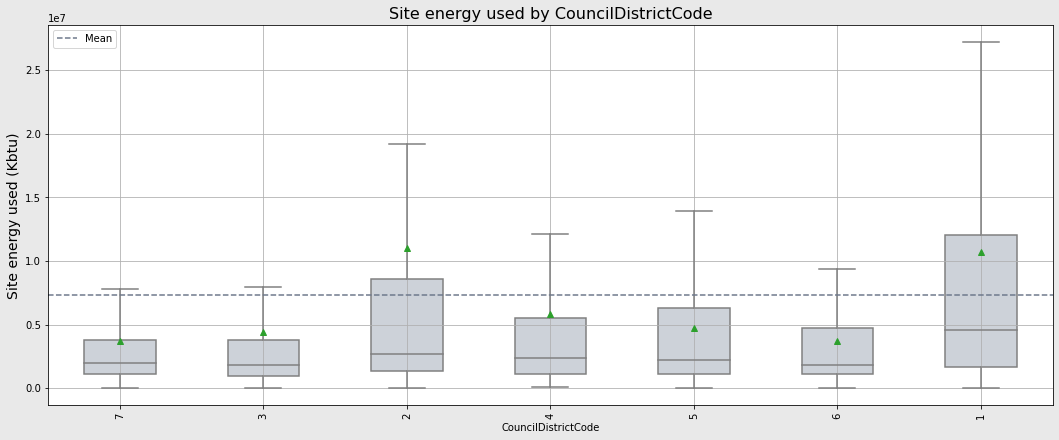

In [107]:
visualisation_eui('CouncilDistrictCode', df)

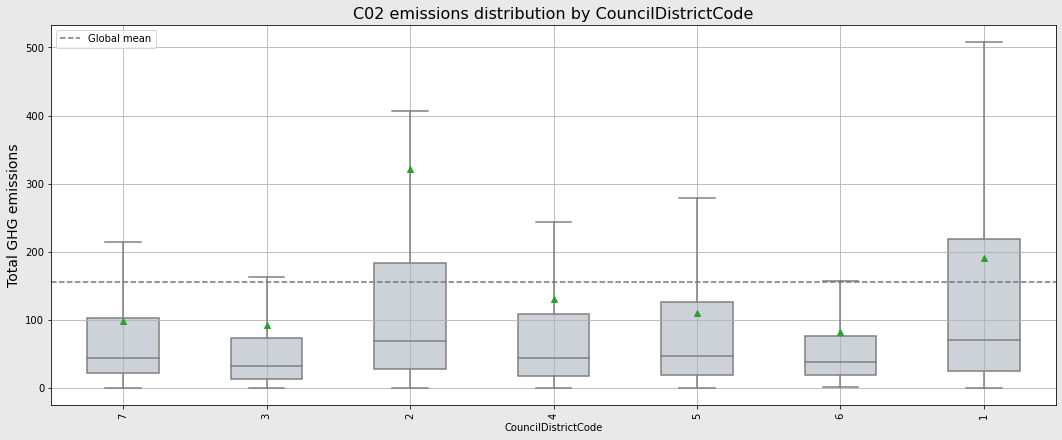

In [108]:
visualisation_ghg('CouncilDistrictCode', df)

The map shows a concentration of high consumming building in the city center. But an homogeneous repartition of the high and low consumption building exists. That why we choose to not use Council district code as a variable for our model because it would be too much arbitrary.

We won't use the Council District Code for clusters but we'll calculate cluster using Kmeans later.

In [109]:
df.drop(columns=['CouncilDistrictCode'], inplace=True)

#### Distribution by Largest property use type

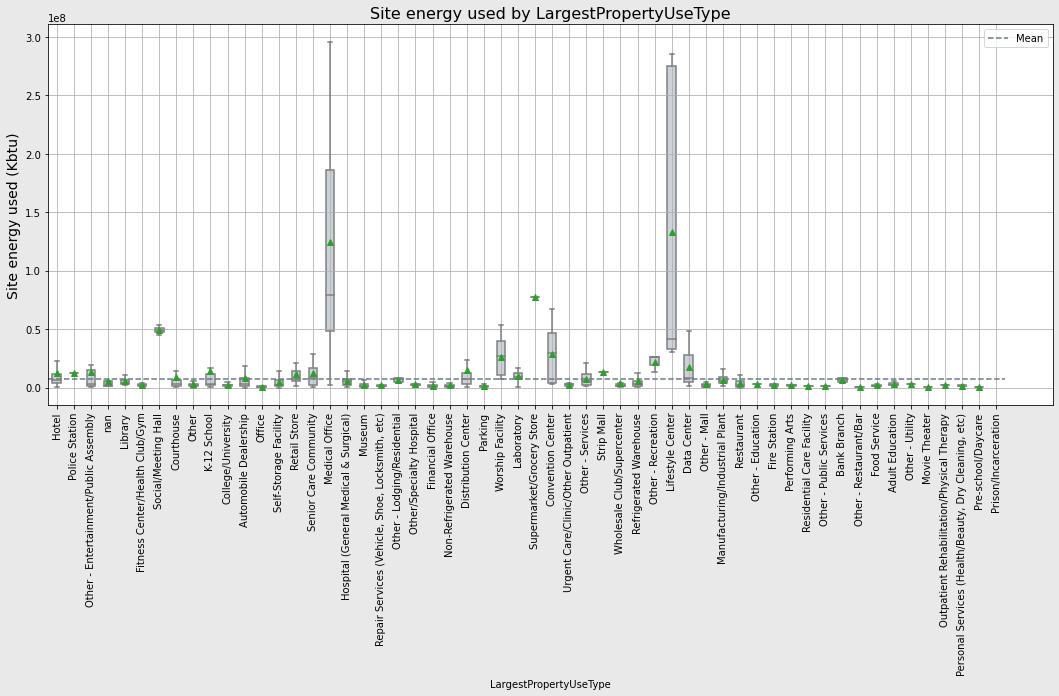

In [110]:
visualisation_eui('LargestPropertyUseType', df)

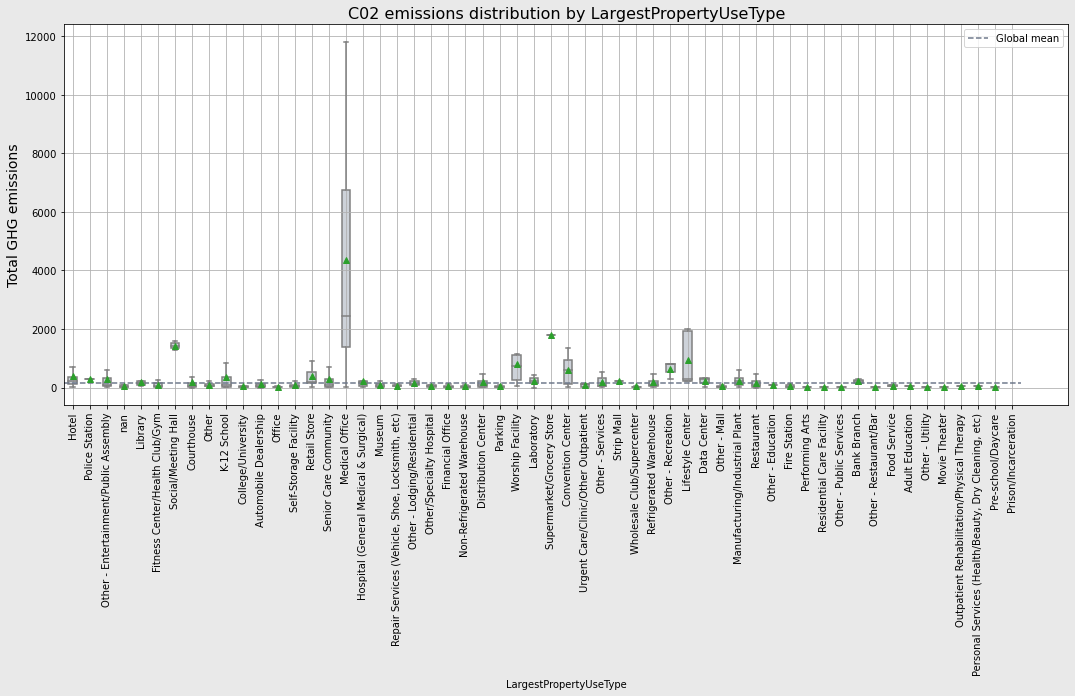

In [111]:
visualisation_ghg('LargestPropertyUseType', df)

Lifestyle center and medical offices show very different distributions.

#### Distribution by Primary Property Type

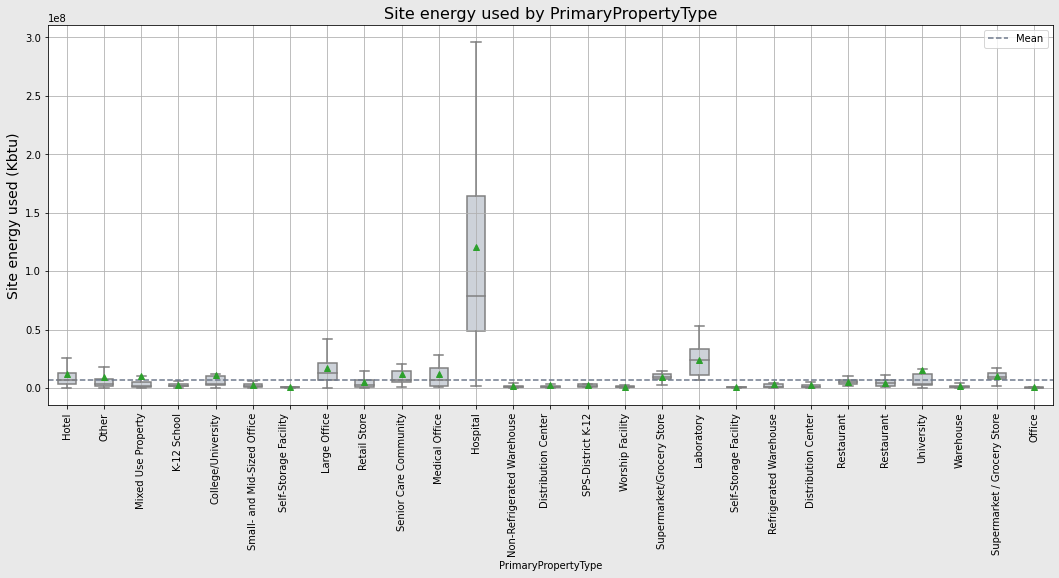

In [112]:
visualisation_eui('PrimaryPropertyType', df)

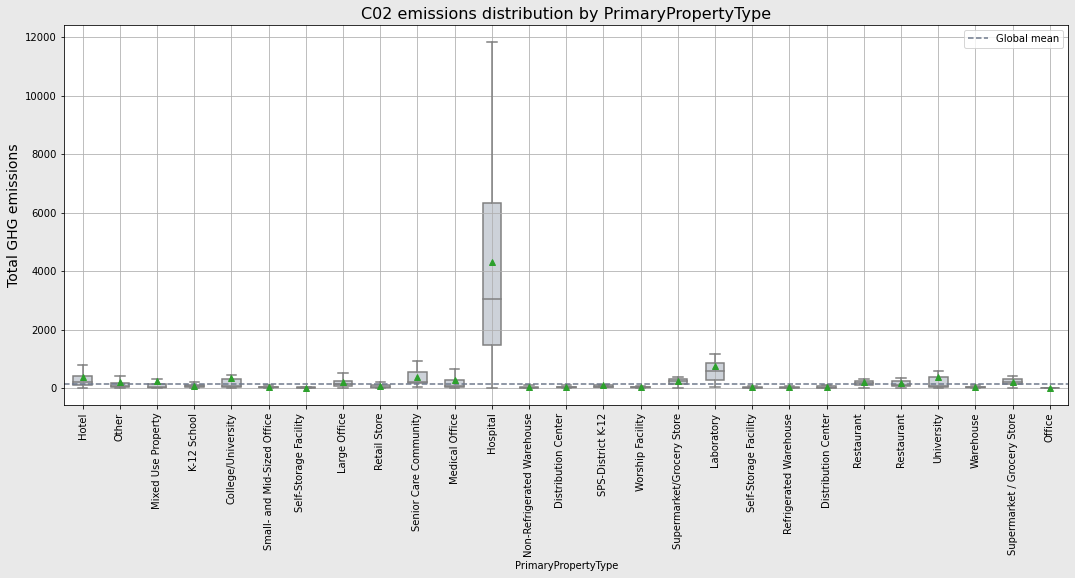

In [113]:
visualisation_ghg('PrimaryPropertyType', df)

We'll keep Primary property use tupe as categortical type variable and drop the largest property use type.

In [114]:
df.drop(columns=['LargestPropertyUseType'], inplace=True)

#### Distribution by Neighborhood

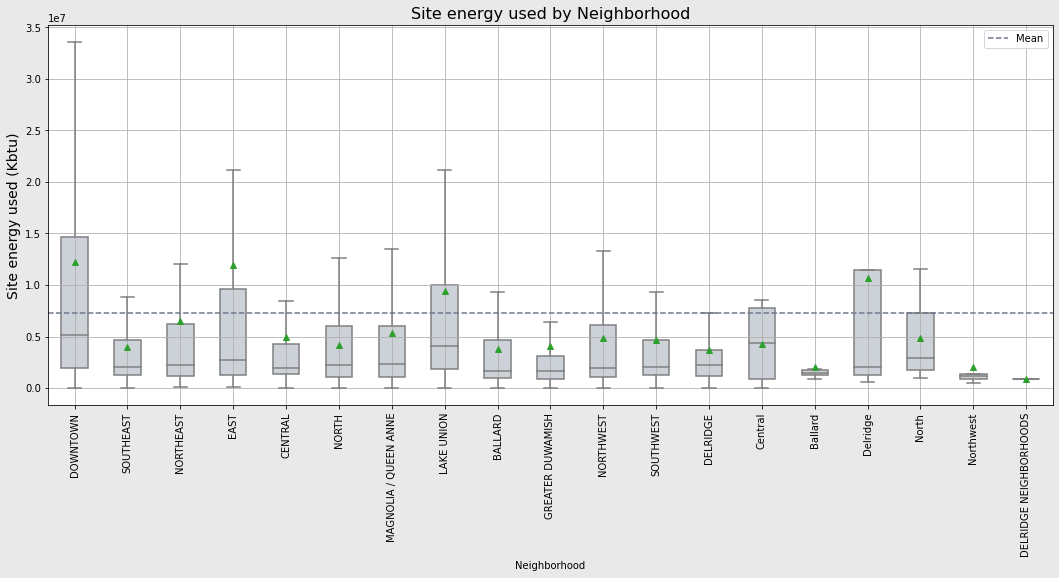

In [115]:
visualisation_eui('Neighborhood', df)

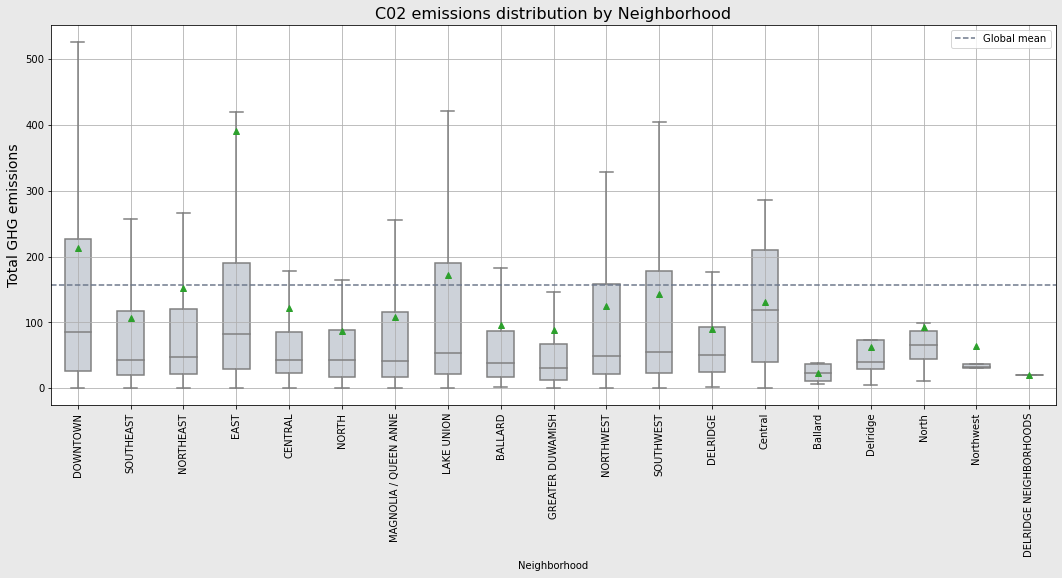

In [116]:
visualisation_ghg('Neighborhood', df)

#### Distribution by Building type

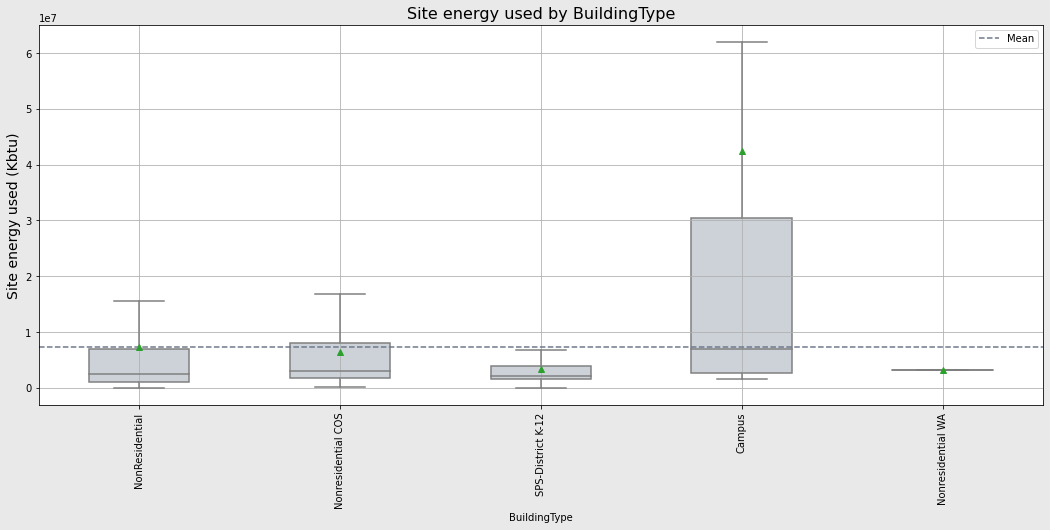

In [117]:
visualisation_eui('BuildingType', df)

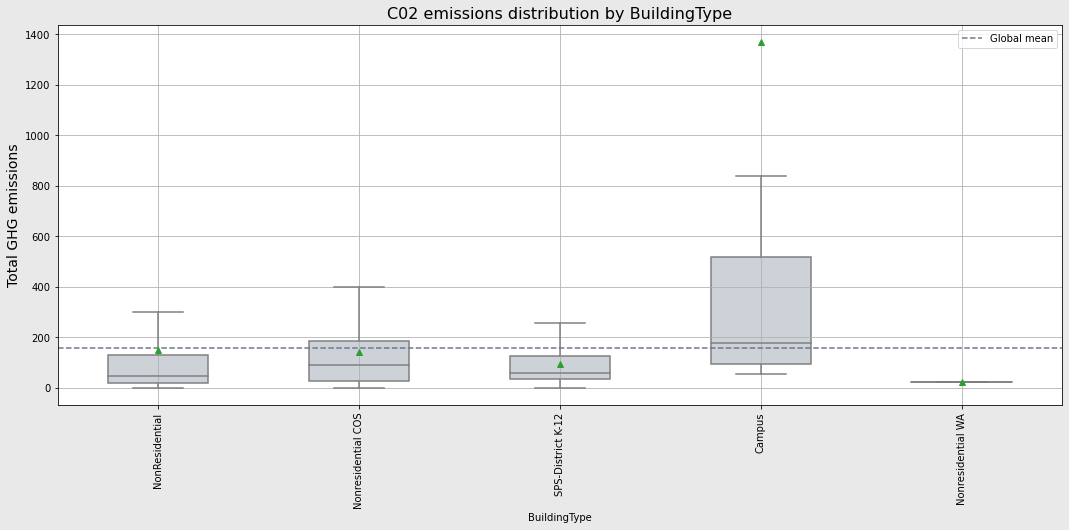

In [118]:
visualisation_ghg('BuildingType', df)

Campus show very different distributions. we'll keep this variable for one hot encoder as well.

## D-  Calculation of type of energy used

The variables electricity, steam and natural gas are already part of the variables site energy use and site energy use intensity.

In consequence, those variables have a high degrees of colinearity. To reduce this we'll calculate a % of use of each type in the total. So we'll have figures a continuous variable between 0 and 1.

In [119]:
# % calculation for each known energy type
df['SteamUse %'] = df['SteamUse(kBtu)'] / df['SiteEnergyUse(kBtu)']
df['Electricity %'] = df['Electricity(kBtu)'] / df['SiteEnergyUse(kBtu)']
df['NaturalGas %'] = df['NaturalGas(kBtu)'] / df['SiteEnergyUse(kBtu)']

#% calculation of a 'other' category type
df['total other type %'] = 1 - (df['SteamUse %'] + df['Electricity %'] + df['NaturalGas %'])


In [120]:
#checking the result
df['temp_total_sum'] = df['SteamUse %'] + df['Electricity %'] + df['NaturalGas %']

In [121]:
df['temp_total_sum'].describe()

count    3104.000000
mean        0.998308
std         0.032434
min         0.000000
25%         1.000000
50%         1.000007
75%         1.000030
max         1.314228
Name: temp_total_sum, dtype: float64

In [122]:
#filtering on the total sum between 0 and 1 only
df = df[df['temp_total_sum']<1]

#droping variable temp_total_sum
df.drop(columns={'temp_total_sum'}, inplace=True)

/Users/jean-baptisteherold/opt/anaconda3/envs/Working/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='total other type %'>

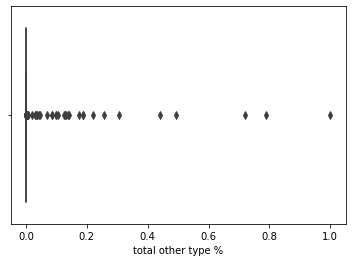

In [123]:
#check
sns.boxplot(df['total other type %'])

In [124]:
df['total other type %'].describe()

count    9.770000e+02
mean     6.387834e-03
std      5.538138e-02
min      1.110223e-16
25%      9.727332e-08
50%      1.465223e-07
75%      2.581756e-07
max      1.000000e+00
Name: total other type %, dtype: float64

In [125]:
df[df['total other type %']>0.4]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,TaxParcelIdentificationNumber,Neighborhood,NumberofFloors,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude,BuildingAge,Location,SteamUse %,Electricity %,NaturalGas %,total other type %
3853,700,2016,NonResidential,Supermarket / Grocery Store,7666201460,MAGNOLIA / QUEEN ANNE,1.0,57176,"Personal Services (Health/Beauty, Dry Cleaning...",31.0,208.800003,1.252517e+07,0.0,0.0,0.0,0.00,0.00,47.63718,-122.37734,8,15thAvenueWest,0.0,0.000000,0.000000,1.000000
3941,803,2016,NonResidential,Small- and Mid-Sized Office,5367202506,Delridge,3.0,85126,Office,1.0,465.500000,3.795171e+07,0.0,18610055.0,685132.0,166.13,1.95,47.54103,-122.33766,87,SWMichigan,0.0,0.490361,0.018053,0.491586
6101,26849,2016,NonResidential,Retail Store,5247802260,DOWNTOWN,2.0,24550,"Office, Retail Store",100.0,39.799999,9.772303e+05,0.0,90201.0,114794.0,6.73,0.27,47.59935,-122.32468,99,SJACKSONSTREET,0.0,0.092303,0.117469,0.790229
6131,26973,2016,NonResidential,Mixed Use Property,6054550000,DOWNTOWN,3.0,49299,"Multifamily Housing, Office, Restaurant",NaN,89.199997,4.729846e+06,0.0,1323792.0,0.0,9.23,0.19,47.59737,-122.32487,107,SouthWellerStreet,0.0,0.279881,0.000000,0.720119
6617,49972,2016,NonResidential,University,1625049001,NORTHEAST,6.0,203030,College/University,NaN,252.000000,5.116831e+07,0.0,28614613.0,0.0,199.48,0.98,47.65356,-122.30613,18,EStevensWayNE,0.0,0.559225,0.000000,0.440775


We'll drop the lines for which we have an other type consumption > 40% as we see those figures might be useless for our predictions as outliers.

In [126]:
#filtering on <0,3% in other type variables 
df = df[df['total other type %']<0.4]

In [127]:
#droping unused columns
df.drop(columns={'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'}, inplace=True)

## H- Drop of unused variables

I have decided to keep primary property use type as categorical data that will be binarized later.

But we'll try to manually binerized the Largest Property type according to if the building is a Medical office or a lifestyle center or not.



As the location seems to have an impact, we saw that the city center contains much more high consumptions building that the rest of the city, so I decided to keep Latitude Longitude and distance from the center as continuous variable in our regression. THe three variables will contains th 3D location of the building starting from the center of Seatle.

THe variables, building type and Largest property use type show significant difference of distribution by each of their category so we'll binerized them later.



In [128]:
df.drop(columns={'ListOfAllPropertyUseTypes', 'Neighborhood', 'TaxParcelIdentificationNumber', 'SiteEUI(kBtu/sf)', 'GHGEmissionsIntensity'}, inplace=True)

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 972 entries, 69 to 6715
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   OSEBuildingID           972 non-null    int64  
 1   DataYear                972 non-null    int64  
 2   BuildingType            972 non-null    object 
 3   PrimaryPropertyType     972 non-null    object 
 4   NumberofFloors          972 non-null    float64
 5   PropertyGFABuilding(s)  972 non-null    int64  
 6   ENERGYSTARScore         670 non-null    float64
 7   SiteEnergyUse(kBtu)     972 non-null    float64
 8   TotalGHGEmissions       972 non-null    float64
 9   Latitude                972 non-null    float64
 10  Longitude               972 non-null    float64
 11  BuildingAge             972 non-null    int64  
 12  Location                972 non-null    object 
 13  SteamUse %              972 non-null    float64
 14  Electricity %           972 non-null    

In [130]:
df.head(5)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,NumberofFloors,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Latitude,Longitude,BuildingAge,Location,SteamUse %,Electricity %,NaturalGas %,total other type %
69,103,2015,Nonresidential COS,Other,1.0,129000,NaN,29337400.0,760.51,47.621241,-122.353432,53,HARRISONST,0.291778,0.487875,0.0,0.220347
70,104,2015,Nonresidential COS,Other,1.0,91213,NaN,5069854.0,123.28,47.621241,-122.353432,53,HARRISONST,0.250500,0.714420,0.0,0.035080
71,106,2015,Nonresidential COS,Other,5.0,396085,NaN,27185096.0,900.81,47.621890,-122.350275,77,HARRISONST,0.402831,0.292970,0.0,0.304199
73,110,2015,Nonresidential COS,Other,2.0,49680,NaN,2632472.0,96.39,47.623936,-122.351930,53,MERCERST,0.434952,0.436669,0.0,0.128378
75,112,2015,Nonresidential COS,Other,2.0,262048,NaN,20828130.0,398.51,47.623881,-122.349970,87,MERCERST,0.187247,0.671386,0.0,0.141367


## I- Creating cluster manually from maps (LAT and LONG)

In [131]:
df['location_type'] = 0
df.loc[df['Latitude'].between(47.60000, 47.63500, inclusive='both') & df['Longitude'].between(-122.3674, -122.3000, inclusive='both'), 'location_type'] = 'city_center'
df.loc[df['Latitude'].between(47.60000, 47.63500, inclusive='both') & df['Longitude'].between(-122.3900, -122.3675, inclusive='both'), 'location_type'] = 'center_both_side'
df.loc[df['Latitude'].between(47.60000, 47.63500, inclusive='both') & df['Longitude'].between(-122.3001, -122.2500, inclusive='both'), 'location_type'] = 'center_both_side'
df.loc[df['Latitude'].between(47.63501, 48.00000, inclusive='both'), 'location_type'] = 'north'
df.loc[df['Latitude'].between(47.48000, 47.59999, inclusive='both'), 'location_type'] = 'south'

In [132]:
df[df['location_type']==0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,NumberofFloors,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Latitude,Longitude,BuildingAge,Location,SteamUse %,Electricity %,NaturalGas %,total other type %,location_type


In [133]:
df.drop(columns=['Latitude', 'Longitude'], inplace=True)

## J- Final preparation<a class="anchor" id="final_prep"></a>

Last adjustments

In [134]:
#checking duplicated OSEBuildingID distributions for each year
duplicates = df[df['OSEBuildingID'].duplicated()]['OSEBuildingID']

In [135]:
df_duplicates = df[df['OSEBuildingID'].isin(duplicates)]

In [136]:
df_duplicates[df_duplicates['DataYear']==2015].describe()

,OSEBuildingID,DataYear,NumberofFloors,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,BuildingAge,SteamUse %,Electricity %,NaturalGas %,total other type %
count,15.000000,15.0,15.000000,1.500000e+01,5.000000,1.500000e+01,15.000000,15.00000,15.000000,15.000000,15.000000,15.000000
mean,9462.666667,2015.0,5.866667,2.098848e+05,94.200000,1.849704e+07,397.656000,55.80000,0.200699,0.678225,0.026791,0.094285
std,14915.535533,0.0,10.266914,2.604492e+05,3.962323,1.977015e+07,504.323758,31.05111,0.190105,0.225543,0.052253,0.089621
min,103.000000,2015.0,1.000000,2.415200e+04,89.000000,5.649300e+04,0.350000,3.00000,0.000000,0.292970,0.000000,0.000045
25%,111.000000,2015.0,1.500000,4.968000e+04,93.000000,2.645048e+06,89.830000,37.00000,0.000000,0.506709,0.000000,0.020689
50%,523.000000,2015.0,2.000000,1.290000e+05,94.000000,1.222961e+07,123.280000,53.00000,0.187247,0.671386,0.000000,0.086522
75%,21450.000000,2015.0,5.500000,2.647590e+05,95.000000,2.826125e+07,579.510000,81.50000,0.348163,0.888476,0.013918,0.134873
max,49725.000000,2015.0,42.000000,1.047934e+06,100.000000,6.674038e+07,1542.470000,111.00000,0.546054,0.993701,0.150081,0.304199


In [137]:
df_duplicates[df_duplicates['DataYear']==2016].describe()

,OSEBuildingID,DataYear,NumberofFloors,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,BuildingAge,SteamUse %,Electricity %,NaturalGas %,total other type %
count,15.000000,15.0,15.000000,1.500000e+01,5.000000,1.500000e+01,15.000000,15.00000,15.000000,15.000000,15.000000,1.500000e+01
mean,9462.666667,2016.0,5.866667,2.273728e+05,93.800000,1.720763e+07,401.599333,56.80000,0.207637,0.692102,0.046379,5.388244e-02
std,14915.535533,0.0,10.266914,2.632065e+05,4.816638,1.815141e+07,483.735185,31.05111,0.209476,0.226239,0.073510,6.643205e-02
min,103.000000,2016.0,1.000000,2.415200e+04,88.000000,1.613634e+05,1.120000,4.00000,0.000000,0.346090,0.000000,1.843041e-07
25%,111.000000,2016.0,1.500000,5.084000e+04,90.000000,2.778522e+06,69.400000,38.00000,0.000000,0.516592,0.000000,9.518750e-05
50%,523.000000,2016.0,2.000000,1.587380e+05,95.000000,1.132551e+07,224.360000,54.00000,0.111659,0.609458,0.000000,3.278533e-02
75%,21450.000000,2016.0,5.500000,3.088900e+05,96.000000,2.230700e+07,549.070000,82.50000,0.438289,0.926267,0.073629,9.232256e-02
max,49725.000000,2016.0,42.000000,1.047934e+06,100.000000,6.176238e+07,1597.560000,112.00000,0.506087,1.000000,0.213649,1.879745e-01


The distribution for duplicated ID are similar for 2015 and 2016 we'll take only the last known year 2016.

In [138]:
print(f'We should have {df.shape[0] - df_duplicates.shape[0]/2} lines in our grouped by dataframe')

We should have 957.0 lines in our grouped by dataframe


In [139]:
mask = df_duplicates[df_duplicates['DataYear']==2015].index
df.drop(mask, axis=0, inplace=True)

In [140]:
df.shape
#OK

(957, 16)

In [141]:
df.drop(columns=['DataYear', 'OSEBuildingID'], inplace=True)

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 957 entries, 3340 to 6715
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   BuildingType            957 non-null    object 
 1   PrimaryPropertyType     957 non-null    object 
 2   NumberofFloors          957 non-null    float64
 3   PropertyGFABuilding(s)  957 non-null    int64  
 4   ENERGYSTARScore         665 non-null    float64
 5   SiteEnergyUse(kBtu)     957 non-null    float64
 6   TotalGHGEmissions       957 non-null    float64
 7   BuildingAge             957 non-null    int64  
 8   Location                957 non-null    object 
 9   SteamUse %              957 non-null    float64
 10  Electricity %           957 non-null    float64
 11  NaturalGas %            957 non-null    float64
 12  total other type %      957 non-null    float64
 13  location_type           957 non-null    object 
dtypes: float64(8), int64(2), object(4)
mem

In [143]:
df.shape

(957, 14)

In [144]:
#exporting cleaned and prepared dataset
df.to_csv('prepared_dataset.csv', sep=',', index=False)